<a href="https://colab.research.google.com/github/TMhdSofyan/Time-Series-Data-Smoothing/blob/main/10_Progress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install jcopml

In [36]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
df = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/02_Well_F12H_FIX.csv', sep=';',  parse_dates=['DATE'], index_col='DATE')
df.head()

,WELL_BORE_CODE,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL
DATE,,,,,,,,,,,
2008-02-12,NO 15/9-F-12 H,308.056,104.418,201.250,18.640,14.48443,106.806,16.295,92.475,285,"38,889"
2008-02-13,NO 15/9-F-12 H,303.034,105.403,182.145,16.467,22.83299,120.889,53.374,89.620,"1,870","285,246"
2008-02-14,NO 15/9-F-12 H,295.586,105.775,181.868,12.660,31.24997,113.718,72.738,80.120,"3,124","509,955"
2008-02-15,NO 15/9-F-12 H,297.663,105.752,180.832,5.264,28.51893,116.831,69.996,84.251,"2,608","383,427"
2008-02-16,NO 15/9-F-12 H,295.936,105.811,180.501,12.385,30.22790,115.434,71.518,82.359,"3,052","418,474"


In [6]:
import pandas as pd

# Replace commas with empty strings in the 'BORE_GAS_VOL' column
df['BORE_OIL_VOL'] = df['BORE_OIL_VOL'].str.replace(',', '')
df['BORE_GAS_VOL'] = df['BORE_GAS_VOL'].str.replace(',', '')

# Convert the 'BORE_GAS_VOL' column to a numeric type
df['BORE_OIL_VOL'] = pd.to_numeric(df['BORE_OIL_VOL'], errors='coerce')
df['BORE_GAS_VOL'] = pd.to_numeric(df['BORE_GAS_VOL'], errors='coerce')

In [7]:
df.drop(columns=['WELL_BORE_CODE', 'AVG_CHOKE_SIZE_P', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
                 'DP_CHOKE_SIZE', 'BORE_GAS_VOL'], inplace = True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df.hist(bins=30, figsize=(13,10))
plt.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/SMARTWELL_HISTPLOT.png', dpi = 600)

In [113]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [ ]:
X = df.drop(columns="BORE_OIL_VOL")
y = df.BORE_OIL_VOL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2139, 4), (917, 4), (2139,), (917,))

In [ ]:
X.columns

Index(['AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_WHP_P', 'AVG_WHT_P'], dtype='object')

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X.columns )])

from sklearn.svm import SVR
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model_SVM1 = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_SVM1.fit(X_train, y_train)

print(model_SVM1.best_params_)
print(model_SVM1.score(X_train, y_train), model_SVM1.best_score_, model_SVM1.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'algo__C': 42.42502238267331, 'algo__gamma': 0.0027814285643757547}
0.888551005929705 0.8647018763392342 0.8912340076781218


In [ ]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_SVM1)
plt.savefig(f'/content/drive/MyDrive/01_Project_Reservoir_Description/Data/SVM_Before_MA.png', dpi=300, bbox_inches='tight')

#Moving Average#


##AVG_WHT_P##

In [ ]:
windows = [5, 10, 15, 20, 25, 30]

for w in windows:
    # create a new figure for each window size
    plt.figure(figsize=(15, 8))
    
    # calculate rolling mean
    rolling_mean = df.rolling(window=w).mean()
    
    # plot scatter of original data
    plt.scatter(df.index, df['AVG_WHT_P'], label='Original Data', s=10)
    
    # plot line of rolling mean
    plt.plot(rolling_mean.index, rolling_mean['AVG_WHT_P'], label=f'Rolling Mean ({w} days)', linewidth=2.5, color='red')
    
    # set plot title and labels
    plt.xlabel('DATE')
    plt.ylabel('AVG_WHT_P')
    plt.title(f'Rolling Mean ({w} days)')
    plt.legend()
    

    # save plot to file
    plt.savefig(f'/content/drive/MyDrive/01_Project_Reservoir_Description/Data/Rolling Mean ({w} days_WHT).png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()

In [10]:
windows = [5, 10, 15, 20, 25, 30]

rolling_means = pd.DataFrame()
for w in windows:
    # calculate rolling mean
    rolling_mean = df['AVG_WHT_P'].rolling(window=w).mean()
    rolling_means[f'Rolling Mean ({w} days)'] = rolling_mean
    
# concatenate rolling_means with the original data
moving_average1 = pd.concat([df, rolling_means], axis=1)

In [11]:
moving_average1.head()

,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_WHP_P,AVG_WHT_P,BORE_OIL_VOL,Rolling Mean (5 days),Rolling Mean (10 days),Rolling Mean (15 days),Rolling Mean (20 days),Rolling Mean (25 days),Rolling Mean (30 days)
DATE,,,,,,,,,,,
2008-02-12,201.250,18.640,106.806,16.295,285,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-13,182.145,16.467,120.889,53.374,1870,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-14,181.868,12.660,113.718,72.738,3124,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-15,180.832,5.264,116.831,69.996,2608,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-16,180.501,12.385,115.434,71.518,3052,56.7842,NaN,NaN,NaN,NaN,NaN


In [12]:
moving_average1.drop(columns=['AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_WHP_P','BORE_OIL_VOL'], inplace=True)

In [13]:
moving_average1.head()

,AVG_WHT_P,Rolling Mean (5 days),Rolling Mean (10 days),Rolling Mean (15 days),Rolling Mean (20 days),Rolling Mean (25 days),Rolling Mean (30 days)
DATE,,,,,,,
2008-02-12,16.295,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-13,53.374,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-14,72.738,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-15,69.996,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-16,71.518,56.7842,NaN,NaN,NaN,NaN,NaN


In [ ]:
moving_average1.hist(bins=30, figsize=(13,10))

In [15]:
moving_average1 = moving_average1.rename(columns={'Rolling Mean (30 days)': 'AVG_WHT_P_MA'})

In [16]:
moving_average1.head()

,AVG_WHT_P,Rolling Mean (5 days),Rolling Mean (10 days),Rolling Mean (15 days),Rolling Mean (20 days),Rolling Mean (25 days),AVG_WHT_P_MA
DATE,,,,,,,
2008-02-12,16.295,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-13,53.374,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-14,72.738,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-15,69.996,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-16,71.518,56.7842,NaN,NaN,NaN,NaN,NaN


##AVG_DP_Tubing##

In [ ]:
windows = [5, 10, 15, 20, 25, 30]

for w in windows:
    # create a new figure for each window size
    plt.figure(figsize=(15, 8))
    
    # calculate rolling mean
    rolling_mean = df.rolling(window=w).mean()
    
    # plot scatter of original data
    plt.scatter(df.index, df['AVG_DP_TUBING'], label='Original Data', s=10)
    
    # plot line of rolling mean
    plt.plot(rolling_mean.index, rolling_mean['AVG_DP_TUBING'], label=f'Rolling Mean ({w} days)', linewidth=2.5, color='red')
    
    # set plot title and labels
    plt.xlabel('DATE')
    plt.ylabel('AVG_DP_TUBING')
    plt.title(f'Rolling Mean ({w} days)')
    plt.legend()
    

    # save plot to file
    plt.savefig(f'/content/drive/MyDrive/01_Project_Reservoir_Description/Data/Rolling Mean ({w} days_Tubing).png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()

In [18]:
windows = [5, 10, 15, 20, 25, 30]

rolling_means = pd.DataFrame()
for w in windows:
    # calculate rolling mean
    rolling_mean = df['AVG_DP_TUBING'].rolling(window=w).mean()
    rolling_means[f'Rolling Mean ({w} days)'] = rolling_mean
    
# concatenate rolling_means with the original data
moving_average2 = pd.concat([df, rolling_means], axis=1)

In [19]:
moving_average2.drop(columns=['AVG_WHT_P', 'AVG_ANNULUS_PRESS', 'AVG_WHP_P','BORE_OIL_VOL'], inplace=True)

array([[<Axes: title={'center': 'AVG_DP_TUBING'}>,
        <Axes: title={'center': 'Rolling Mean (5 days)'}>,
        <Axes: title={'center': 'Rolling Mean (10 days)'}>],
       [<Axes: title={'center': 'Rolling Mean (15 days)'}>,
        <Axes: title={'center': 'Rolling Mean (20 days)'}>,
        <Axes: title={'center': 'Rolling Mean (25 days)'}>],
       [<Axes: title={'center': 'Rolling Mean (30 days)'}>, <Axes: >,
        <Axes: >]], dtype=object)

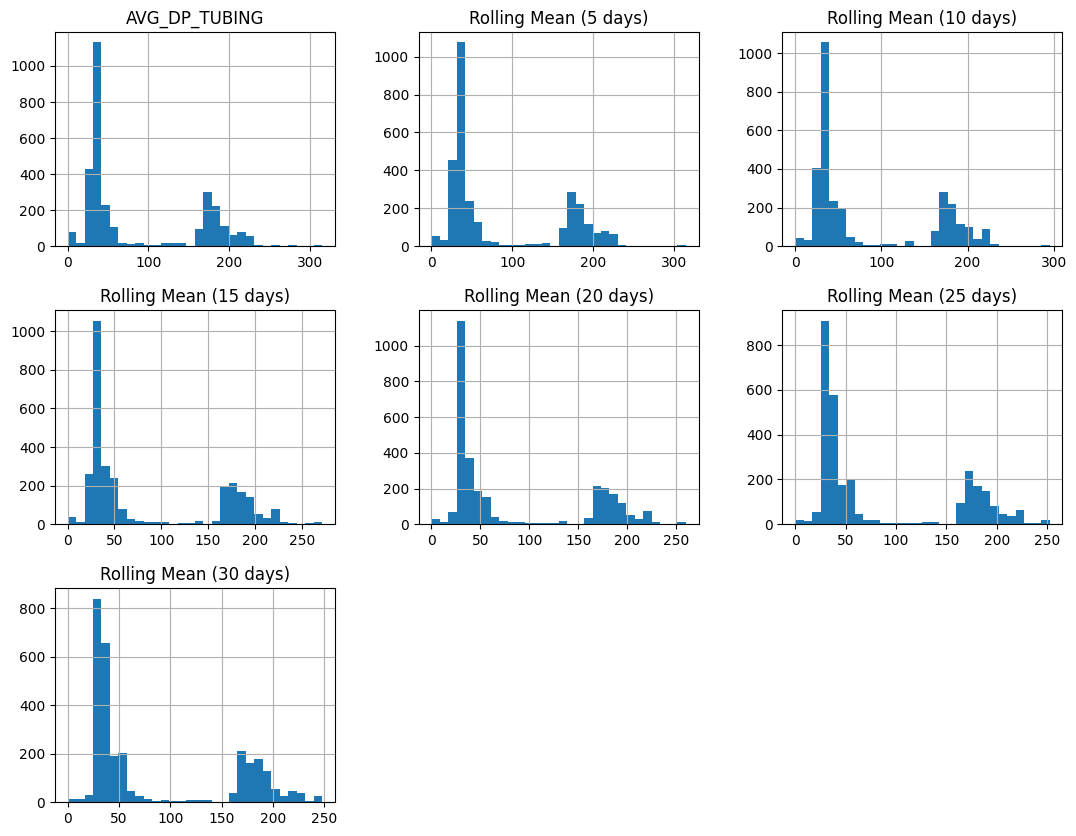

In [20]:
moving_average2.hist(bins=30, figsize=(13,10))

In [21]:
moving_average2 = moving_average2.rename(columns={'Rolling Mean (30 days)': 'AVG_DP_TUBING_MA'})

In [22]:
moving_average2.head()

,AVG_DP_TUBING,Rolling Mean (5 days),Rolling Mean (10 days),Rolling Mean (15 days),Rolling Mean (20 days),Rolling Mean (25 days),AVG_DP_TUBING_MA
DATE,,,,,,,
2008-02-12,201.250,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-13,182.145,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-14,181.868,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-15,180.832,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-16,180.501,185.3192,NaN,NaN,NaN,NaN,NaN


#Prediksi After Moving Average#

In [23]:
new_df = pd.concat([df, moving_average1[['AVG_WHT_P_MA']], moving_average2[['AVG_DP_TUBING_MA']]], axis=1)

In [24]:
new_df.drop(columns=['AVG_DP_TUBING', 'AVG_WHT_P'], inplace = True)

In [25]:
new_df.head()

,AVG_ANNULUS_PRESS,AVG_WHP_P,BORE_OIL_VOL,AVG_WHT_P_MA,AVG_DP_TUBING_MA
DATE,,,,,
2008-02-12,18.640,106.806,285,NaN,NaN
2008-02-13,16.467,120.889,1870,NaN,NaN
2008-02-14,12.660,113.718,3124,NaN,NaN
2008-02-15,5.264,116.831,2608,NaN,NaN
2008-02-16,12.385,115.434,3052,NaN,NaN


In [26]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3056 entries, 2008-02-12 to 2016-09-17
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AVG_ANNULUS_PRESS  3043 non-null   float64
 1   AVG_WHP_P          3056 non-null   float64
 2   BORE_OIL_VOL       3056 non-null   int64  
 3   AVG_WHT_P_MA       3027 non-null   float64
 4   AVG_DP_TUBING_MA   2992 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 143.2 KB


In [27]:
from jcopml.plot import plot_missing_value

In [ ]:
plot_missing_value(new_df)

In [29]:
X1 = new_df.drop(columns="BORE_OIL_VOL")
y1 = new_df.BORE_OIL_VOL

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((2139, 4), (917, 4), (2139,), (917,))

In [ ]:
X1.columns

Index(['AVG_ANNULUS_PRESS', 'AVG_WHP_P', 'AVG_WHT_P_MA', 'AVG_DP_TUBING_MA'], dtype='object')

In [31]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X1.columns )])

from sklearn.svm import SVR
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model_SVM2 = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_SVM2.fit(X1_train, y1_train)

print(model_SVM2.best_params_)
print(model_SVM2.score(X1_train, y1_train), model_SVM2.best_score_, model_SVM2.score(X1_test, y1_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__C': 42.42502238267331, 'algo__gamma': 0.0027814285643757547}
0.8339312075328367 0.8022994321641989 0.8170463468476032


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
plot_actual_vs_prediction(X1_train, y1_train, X1_test, y1_test, model_SVM2)
plt.savefig(f'/content/drive/MyDrive/01_Project_Reservoir_Description/Data/SVM_After_MA_NEW.png', dpi=300, bbox_inches='tight')

#Savitzky-Golay For Tubing#

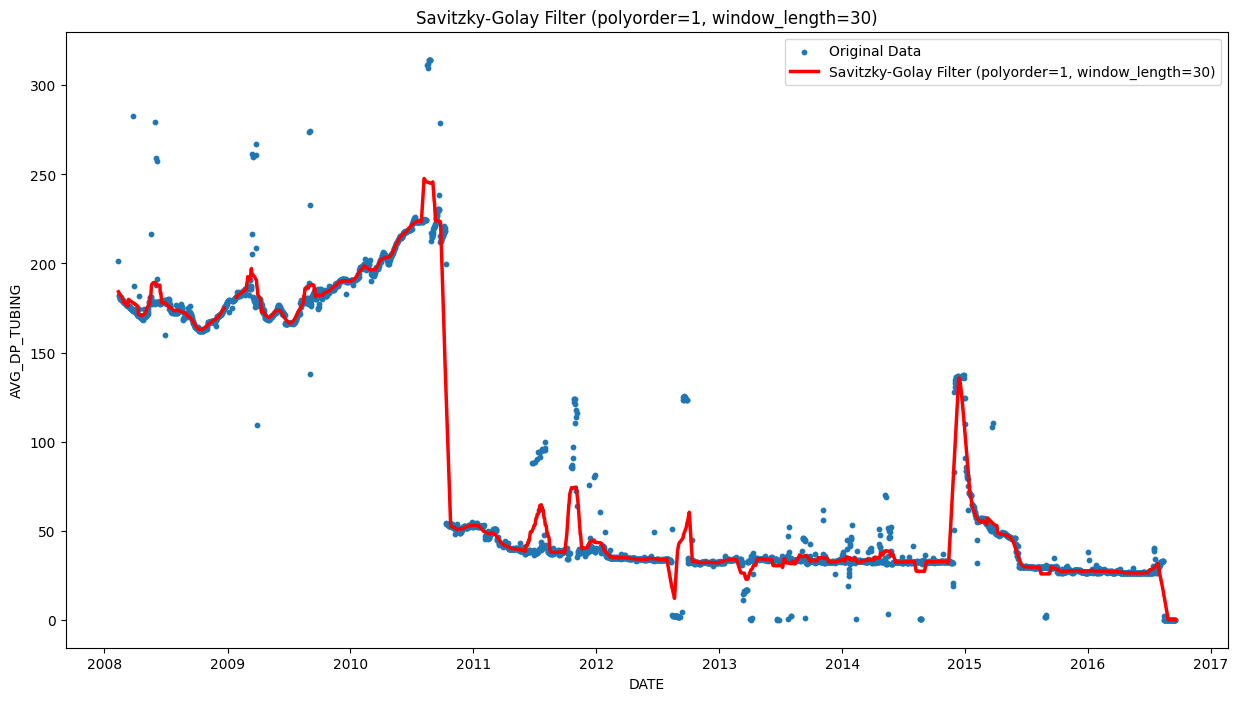

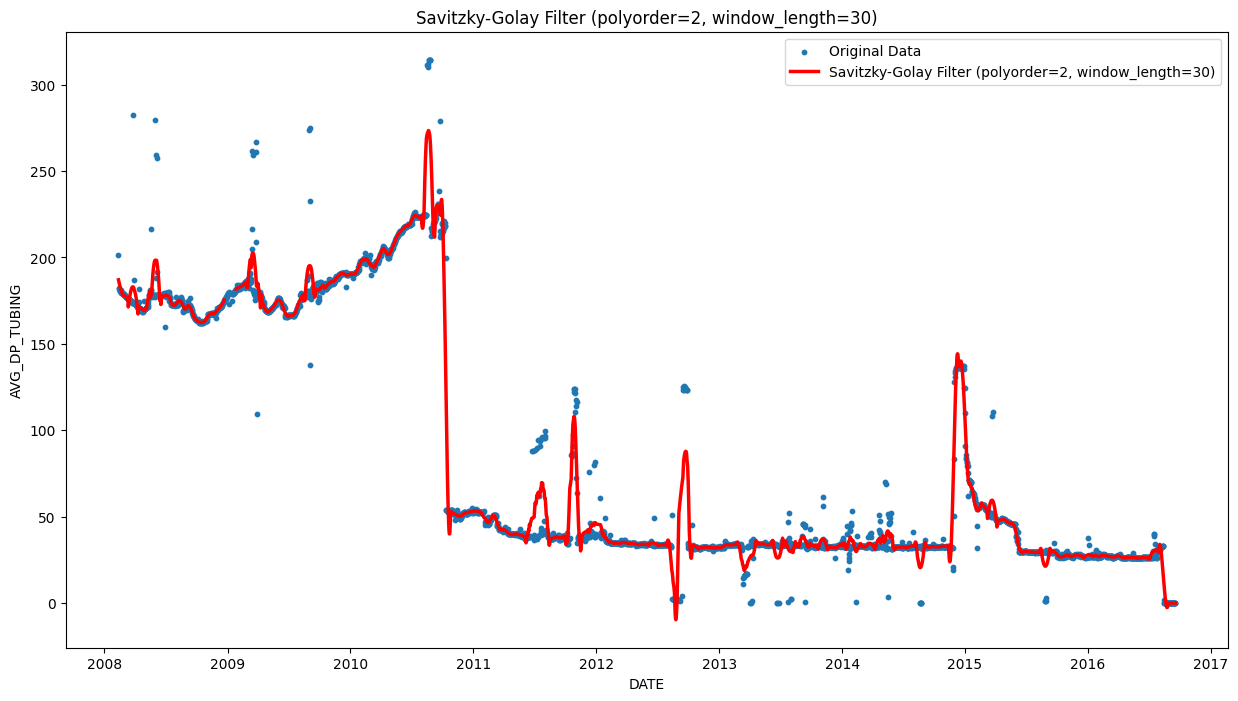

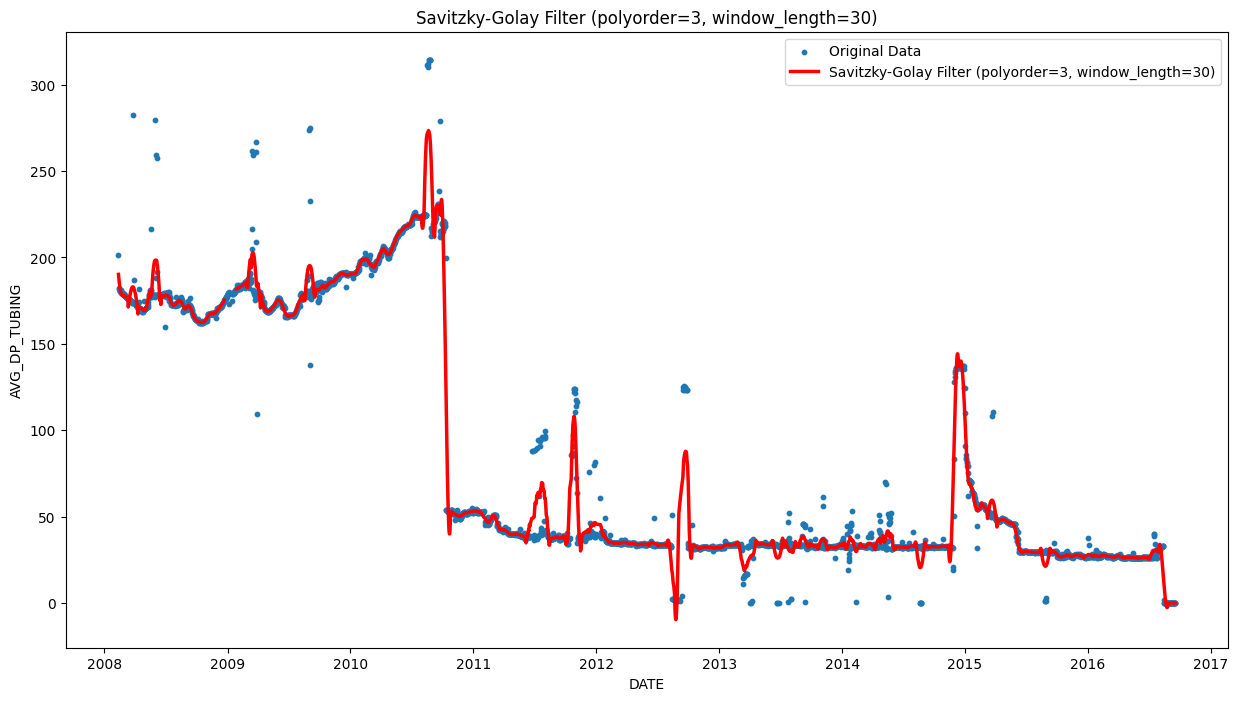

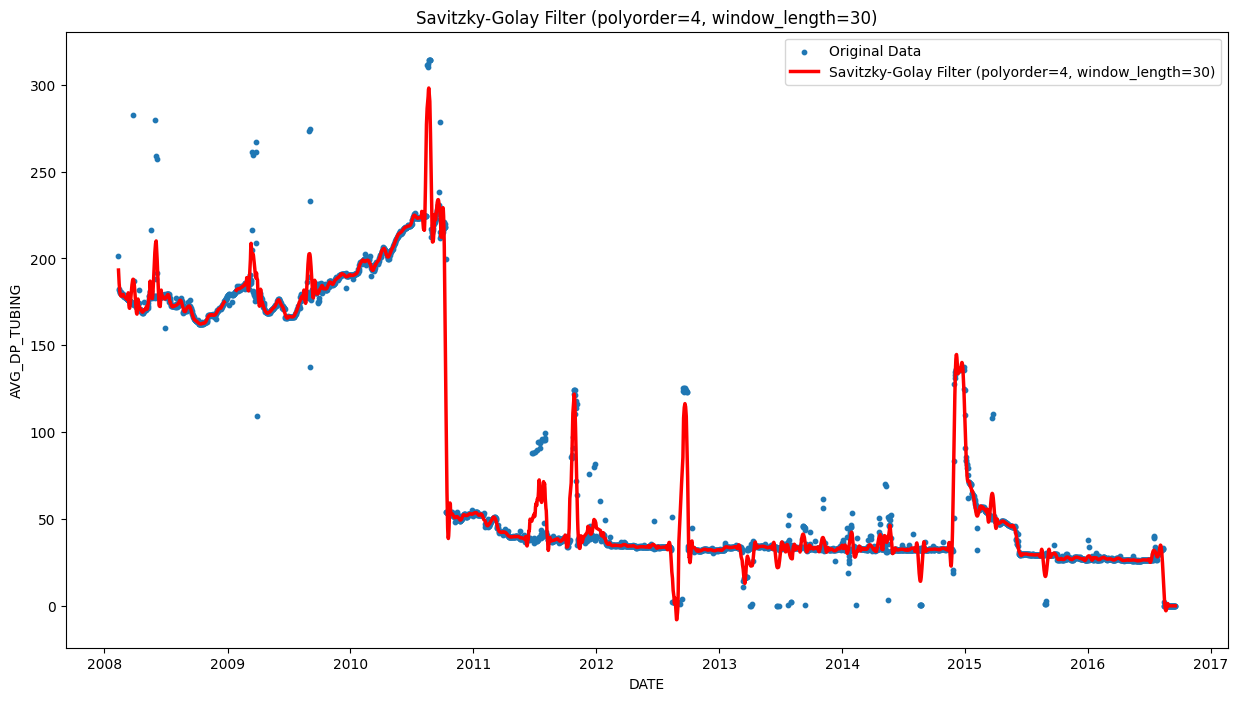

In [37]:
from scipy.signal import savgol_filter

polynomial_values = [1, 2, 3, 4]
window_length = 30

for p in polynomial_values:
    # create a new figure for each polynomial value
    plt.figure(figsize=(15, 8))
    
    # apply Savitzky-Golay filter
    sg = savgol_filter(df['AVG_DP_TUBING'], window_length=window_length, polyorder=p)
    
    # plot scatter of original data
    plt.scatter(df.index, df['AVG_DP_TUBING'], label='Original Data', s=10)
    
    # plot line of filtered data
    plt.plot(df.index, sg, label=f'Savitzky-Golay Filter (polyorder={p}, window_length={window_length})', linewidth=2.5, color='red')
    
    # set plot title and labels
    plt.xlabel('DATE')
    plt.ylabel('AVG_DP_TUBING')
    plt.title(f'Savitzky-Golay Filter (polyorder={p}, window_length={window_length})')
    plt.legend()
    
    # save plot to file
    plt.savefig(f'/content/drive/MyDrive/01_Project_Reservoir_Description/Data/Savitzky-Golay Filter (polyorder={p}, window_length={window_length}).png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()


In [74]:
from scipy.signal import savgol_filter

windows_length = 30
polynomial_values = [1, 2, 3, 4]

savgol_data = pd.DataFrame()

for p in polynomial_values:
    # apply Savitzky-Golay filter
    savgol_result = savgol_filter(df['AVG_DP_TUBING'], window_length=windows_length, polyorder=p, mode='mirror')
    savgol_data[f'Savitzky-Golay ({windows_length} days, {p} polynomial)'] = savgol_result

In [75]:
savgol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Savitzky-Golay (30 days, 1 polynomial)  3021 non-null   float64
 1   Savitzky-Golay (30 days, 2 polynomial)  3021 non-null   float64
 2   Savitzky-Golay (30 days, 3 polynomial)  3021 non-null   float64
 3   Savitzky-Golay (30 days, 4 polynomial)  3021 non-null   float64
dtypes: float64(4)
memory usage: 95.6 KB


In [66]:
savgol_data.head()

,"Savitzky-Golay (30 days, 1 polynomial)","Savitzky-Golay (30 days, 2 polynomial)","Savitzky-Golay (30 days, 3 polynomial)","Savitzky-Golay (30 days, 4 polynomial)"
0,180.746000,182.631700,182.631700,183.805827
1,180.733233,182.576189,182.576189,183.646313
2,180.710200,182.458530,182.458530,183.351860
3,180.667200,182.299204,182.299204,182.901822
4,180.615800,182.087172,182.087172,182.321543


In [76]:
savgol_data = savgol_data.fillna(savgol_data.mean())

In [79]:
savgol_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3056 entries, 2008-02-12 to 2016-09-17
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Savitzky-Golay (30 days, 1 polynomial)  3056 non-null   float64
 1   Savitzky-Golay (30 days, 2 polynomial)  3056 non-null   float64
 2   Savitzky-Golay (30 days, 3 polynomial)  3056 non-null   float64
 3   Savitzky-Golay (30 days, 4 polynomial)  3056 non-null   float64
dtypes: float64(4)
memory usage: 119.4 KB


In [80]:
savgol_data = savgol_data.set_index(df.index)

In [83]:
savgol_data.head()

,"Savitzky-Golay (30 days, 1 polynomial)","Savitzky-Golay (30 days, 2 polynomial)","Savitzky-Golay (30 days, 3 polynomial)","Savitzky-Golay (30 days, 4 polynomial)"
DATE,,,,
2008-02-12,180.746000,182.631700,182.631700,183.805827
2008-02-13,180.733233,182.576189,182.576189,183.646313
2008-02-14,180.710200,182.458530,182.458530,183.351860
2008-02-15,180.667200,182.299204,182.299204,182.901822
2008-02-16,180.615800,182.087172,182.087172,182.321543


In [84]:
savgol_data = savgol_data.rename(columns={'Savitzky-Golay (30 days, 1 polynomial)': 'AVG_DP_TUBING_SG'})

#Savitzky-Golay for WHT P

In [ ]:
from scipy.signal import savgol_filter

polynomial_values = [1, 2, 3, 4]
window_length = 30

for p in polynomial_values:
    # create a new figure for each polynomial value
    plt.figure(figsize=(15, 8))
    
    # apply Savitzky-Golay filter
    sg = savgol_filter(df['AVG_WHT_P'], window_length=window_length, polyorder=p)
    
    # plot scatter of original data
    plt.scatter(df.index, df['AVG_WHT_P'], label='Original Data', s=10)
    
    # plot line of filtered data
    plt.plot(df.index, sg, label=f'Savitzky-Golay Filter (polyorder={p}, window_length={window_length})', linewidth=2.5, color='red')
    
    # set plot title and labels
    plt.xlabel('DATE')
    plt.ylabel('AVG_WHT_P')
    plt.title(f'Savitzky-Golay Filter (polyorder={p}, window_length={window_length})')
    plt.legend()
    
    # save plot to file
    plt.savefig(f'/content/drive/MyDrive/01_Project_Reservoir_Description/Data/Savitzky-Golay Filter (polyorder={p}, window_length={window_length})AVG_WHT_P.png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()

In [96]:
from scipy.signal import savgol_filter

windows_length = 30
polynomial_values = [1, 2, 3, 4]

savgol_data1 = pd.DataFrame()

for p in polynomial_values:
    # apply Savitzky-Golay filter
    savgol_result = savgol_filter(df['AVG_WHT_P'], window_length=windows_length, polyorder=p)
    savgol_data1[f'Savitzky-Golay ({windows_length} days, {p} polynomial)'] = savgol_result

In [97]:
savgol_data1.head()

,"Savitzky-Golay (30 days, 1 polynomial)","Savitzky-Golay (30 days, 2 polynomial)","Savitzky-Golay (30 days, 3 polynomial)","Savitzky-Golay (30 days, 4 polynomial)"
0,63.030839,52.785288,42.454242,33.469234
1,63.545588,55.419806,49.363676,46.575225
2,64.060337,57.902912,55.358320,56.774676
3,64.575086,60.234606,60.494720,64.468385
4,65.089835,62.414888,64.829424,70.030673


In [98]:
savgol_data1 = savgol_data1.fillna(savgol_data.mean())

In [100]:
savgol_data1 = savgol_data1.set_index(df.index)
savgol_data1.head()

,"Savitzky-Golay (30 days, 1 polynomial)","Savitzky-Golay (30 days, 2 polynomial)","Savitzky-Golay (30 days, 3 polynomial)","Savitzky-Golay (30 days, 4 polynomial)"
DATE,,,,
2008-02-12,63.030839,52.785288,42.454242,33.469234
2008-02-13,63.545588,55.419806,49.363676,46.575225
2008-02-14,64.060337,57.902912,55.358320,56.774676
2008-02-15,64.575086,60.234606,60.494720,64.468385
2008-02-16,65.089835,62.414888,64.829424,70.030673


In [101]:
savgol_data1 = savgol_data1.rename(columns={'Savitzky-Golay (30 days, 1 polynomial)': 'AVG_WHT_P_SG'})

#PREDIKSI AFTER SAVITZKY_GOLAY SMOOTHING

In [102]:
new_df2 = pd.concat([df, savgol_data[['AVG_DP_TUBING_SG']], savgol_data1[['AVG_WHT_P_SG']]], axis=1)

In [103]:
new_df2.head()

,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_WHP_P,AVG_WHT_P,BORE_OIL_VOL,AVG_DP_TUBING_SG,AVG_WHT_P_SG
DATE,,,,,,,
2008-02-12,201.250,18.640,106.806,16.295,285,180.746000,63.030839
2008-02-13,182.145,16.467,120.889,53.374,1870,180.733233,63.545588
2008-02-14,181.868,12.660,113.718,72.738,3124,180.710200,64.060337
2008-02-15,180.832,5.264,116.831,69.996,2608,180.667200,64.575086
2008-02-16,180.501,12.385,115.434,71.518,3052,180.615800,65.089835


array([[<Axes: title={'center': 'AVG_DP_TUBING'}>,
        <Axes: title={'center': 'AVG_ANNULUS_PRESS'}>,
        <Axes: title={'center': 'AVG_WHP_P'}>],
       [<Axes: title={'center': 'AVG_WHT_P'}>,
        <Axes: title={'center': 'BORE_OIL_VOL'}>,
        <Axes: title={'center': 'AVG_DP_TUBING_SG'}>],
       [<Axes: title={'center': 'AVG_WHT_P_SG'}>, <Axes: >, <Axes: >]],
      dtype=object)

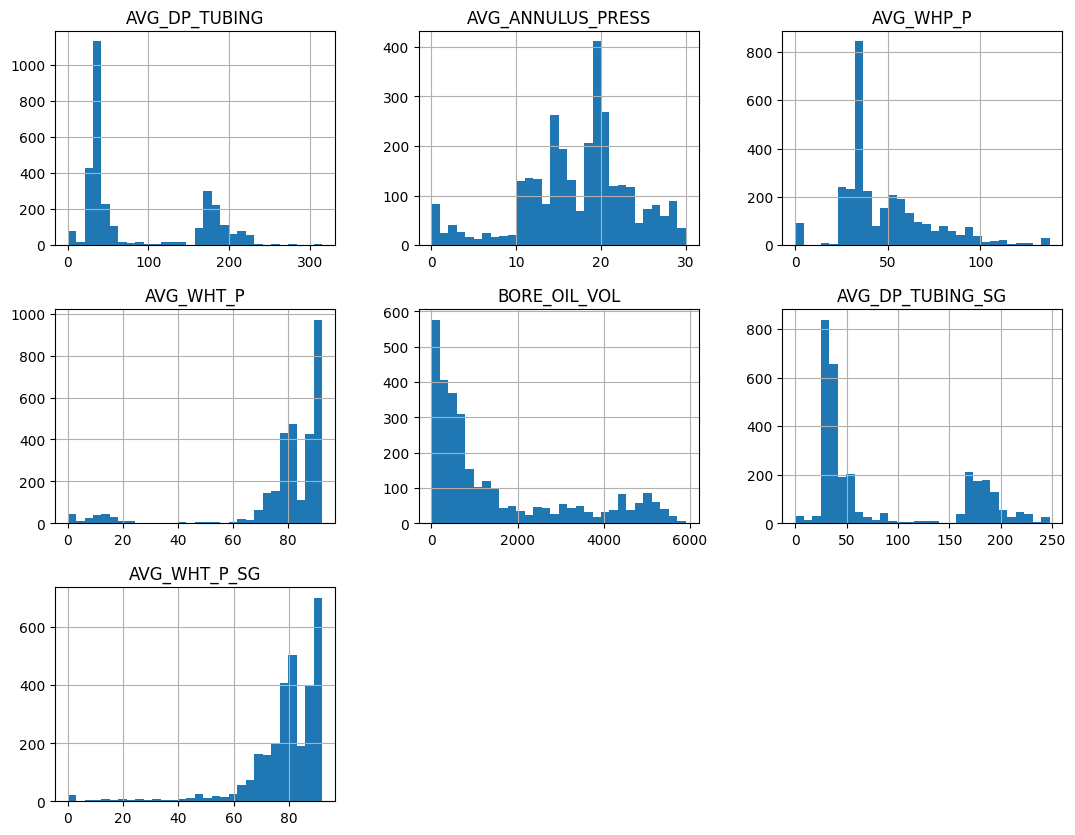

In [104]:
new_df2.hist(bins=30, figsize=(13,10))

In [105]:
new_df2.drop(columns=['AVG_DP_TUBING', 'AVG_WHT_P'], inplace = True)

In [106]:
new_df2.head()

,AVG_ANNULUS_PRESS,AVG_WHP_P,BORE_OIL_VOL,AVG_DP_TUBING_SG,AVG_WHT_P_SG
DATE,,,,,
2008-02-12,18.640,106.806,285,180.746000,63.030839
2008-02-13,16.467,120.889,1870,180.733233,63.545588
2008-02-14,12.660,113.718,3124,180.710200,64.060337
2008-02-15,5.264,116.831,2608,180.667200,64.575086
2008-02-16,12.385,115.434,3052,180.615800,65.089835


In [108]:
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3056 entries, 2008-02-12 to 2016-09-17
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AVG_ANNULUS_PRESS  3043 non-null   float64
 1   AVG_WHP_P          3056 non-null   float64
 2   BORE_OIL_VOL       3056 non-null   int64  
 3   AVG_DP_TUBING_SG   3056 non-null   float64
 4   AVG_WHT_P_SG       3056 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 207.8 KB


In [110]:
X1 = new_df2.drop(columns="BORE_OIL_VOL")
y1 = new_df2.BORE_OIL_VOL

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((2139, 4), (917, 4), (2139,), (917,))

In [111]:
y1_train.isnull().sum()

0

In [112]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X1.columns )])

from sklearn.svm import SVR
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model_SVM2 = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_SVM2.fit(X1_train, y1_train)

print(model_SVM2.best_params_)
print(model_SVM2.score(X1_train, y1_train), model_SVM.best_score_, model_SVM2.score(X1_test, y1_test))

NameError: ignored

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax', transform= 'yeo-johnson' , poly = 3), X.columns )])


from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3, n_iter=50,  n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 79, 'algo__max_features': 0.3347462573473682, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 147, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.9949395113481777 0.9577794851913589 0.9599238218326979


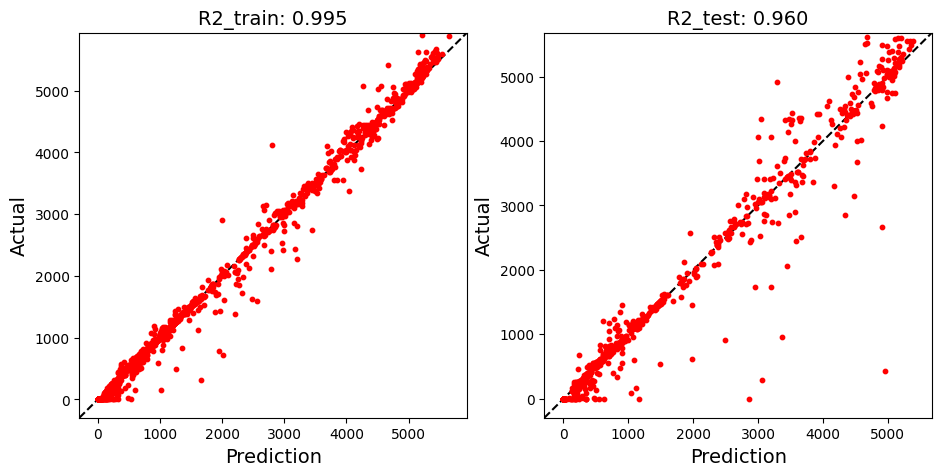

In [ ]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_RF)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3037 entries, 2008-02-12 to 2016-09-17
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AVG_DOWNHOLE_PRESSURE     3037 non-null   float64
 1   AVG_DOWNHOLE_TEMPERATURE  3037 non-null   float64
 2   AVG_DP_TUBING             3037 non-null   float64
 3   AVG_ANNULUS_PRESS         3037 non-null   float64
 4   AVG_WHP_P                 3037 non-null   float64
 5   AVG_WHT_P                 3037 non-null   float64
 6   BORE_OIL_VOL              3037 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 254.4 KB


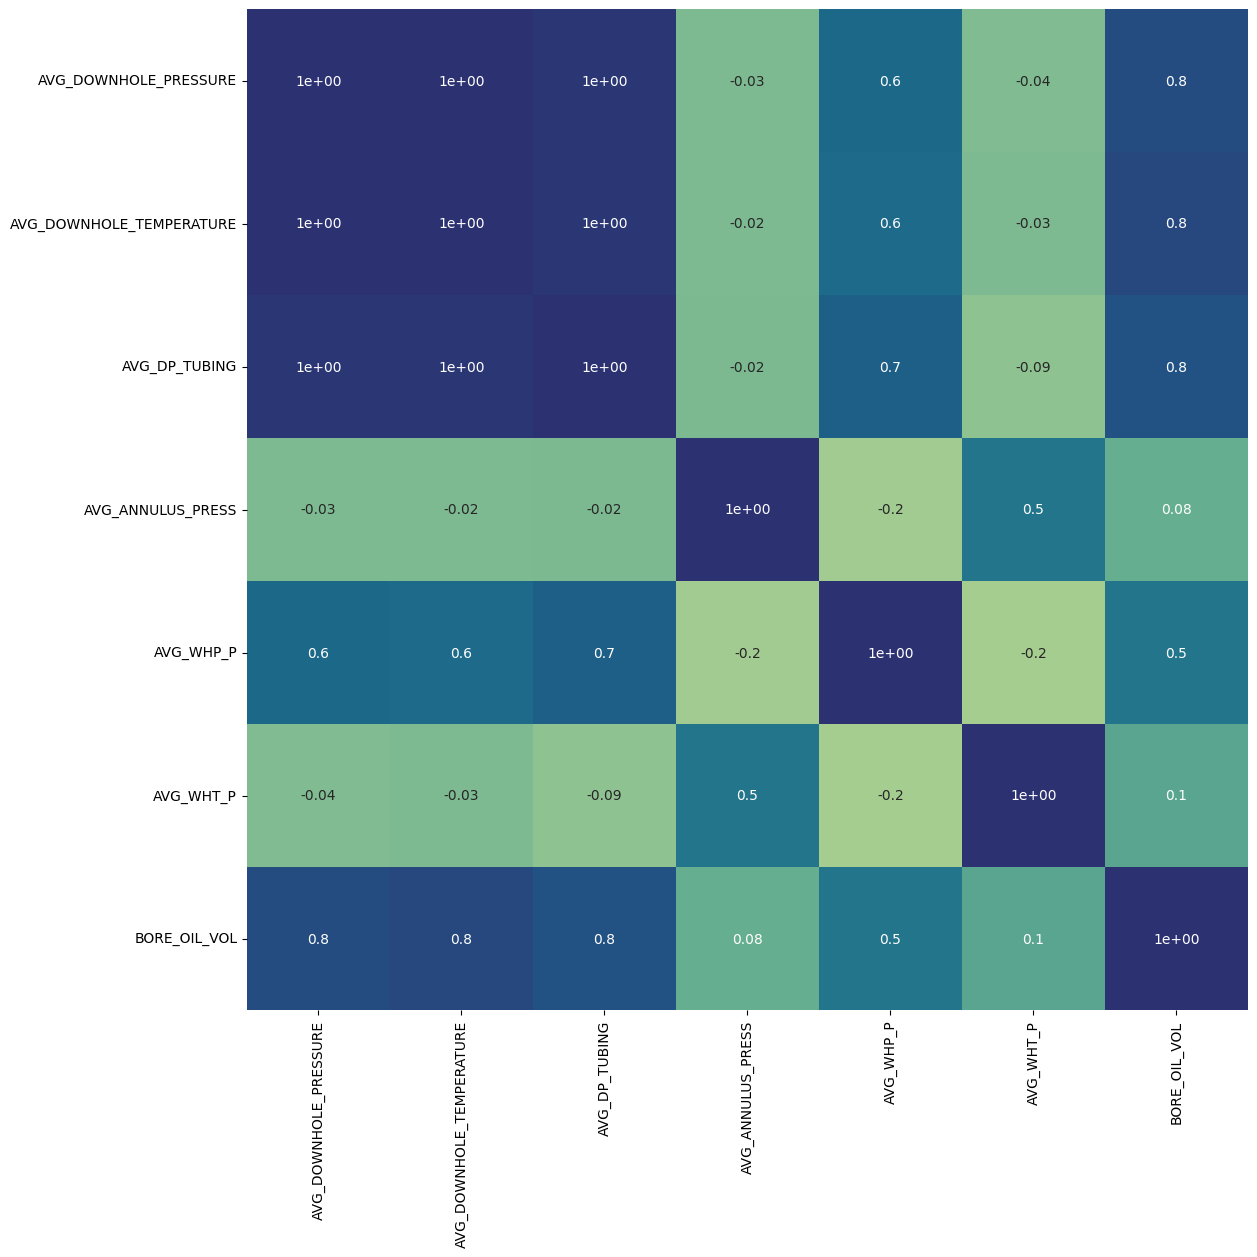

In [ ]:

plt.figure(figsize = (17, 13))
sns.heatmap(df1.corr(), cmap= "crest", cbar= False, annot= True, square= True, fmt= '.1')
plt.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/corrplot_600dpi.png', dpi = 600)

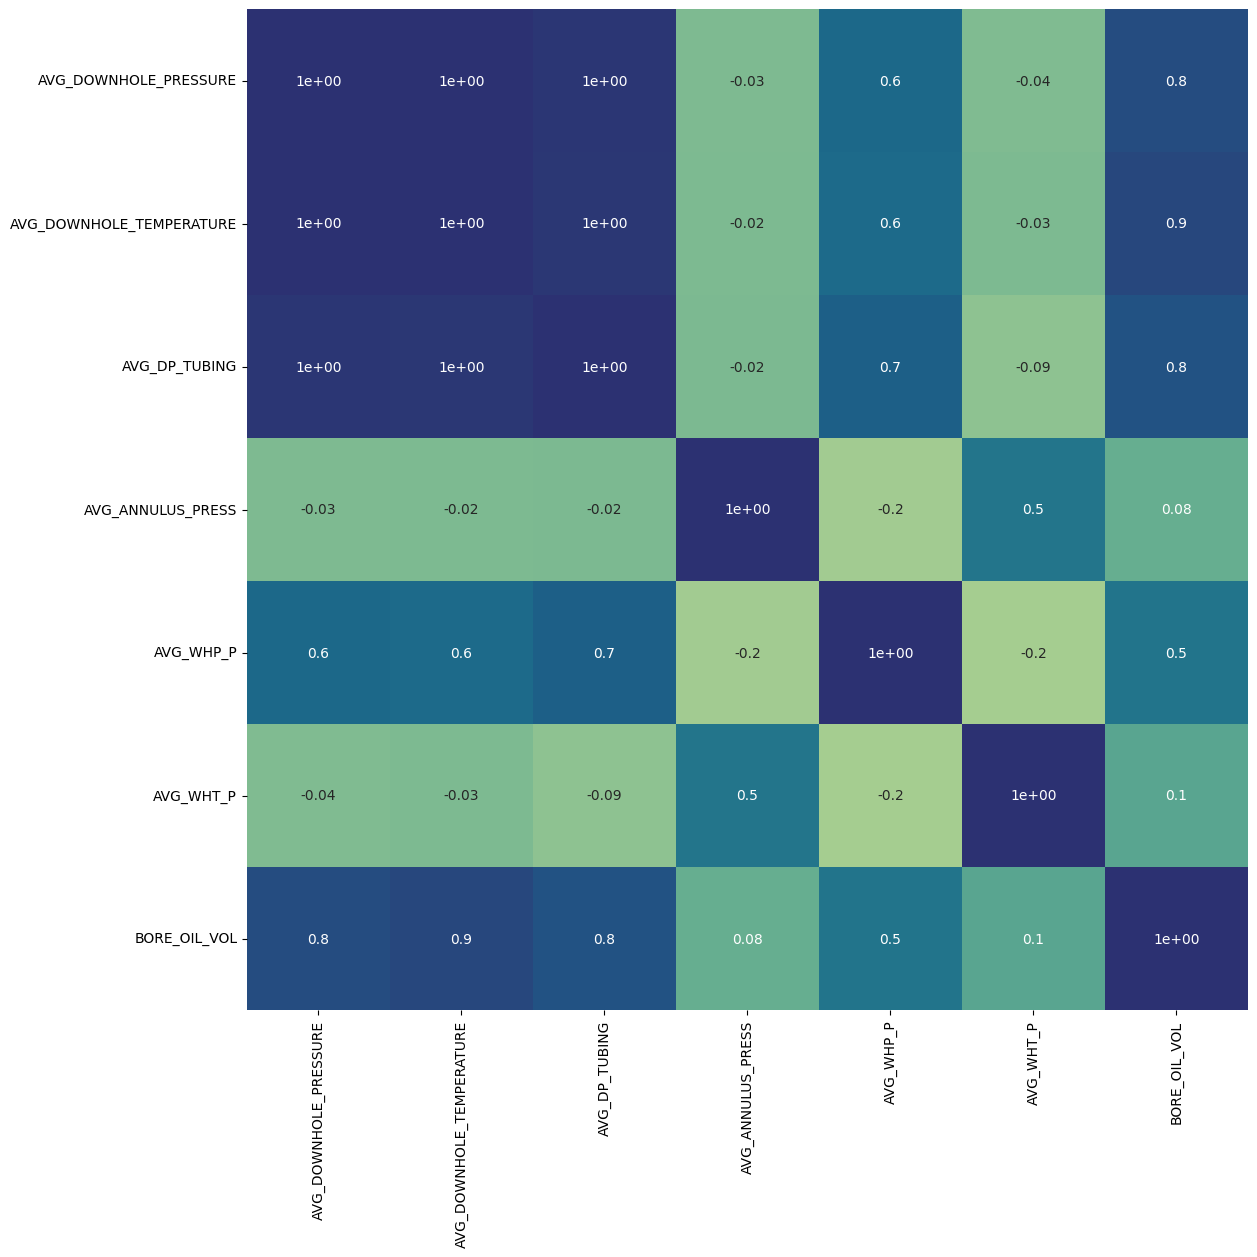

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (17, 13))
sns.heatmap(df.corr(), cmap= "crest", cbar= False, annot= True, square= True, fmt= '.1')
plt.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/corrplot_600dpi.png', dpi = 600)

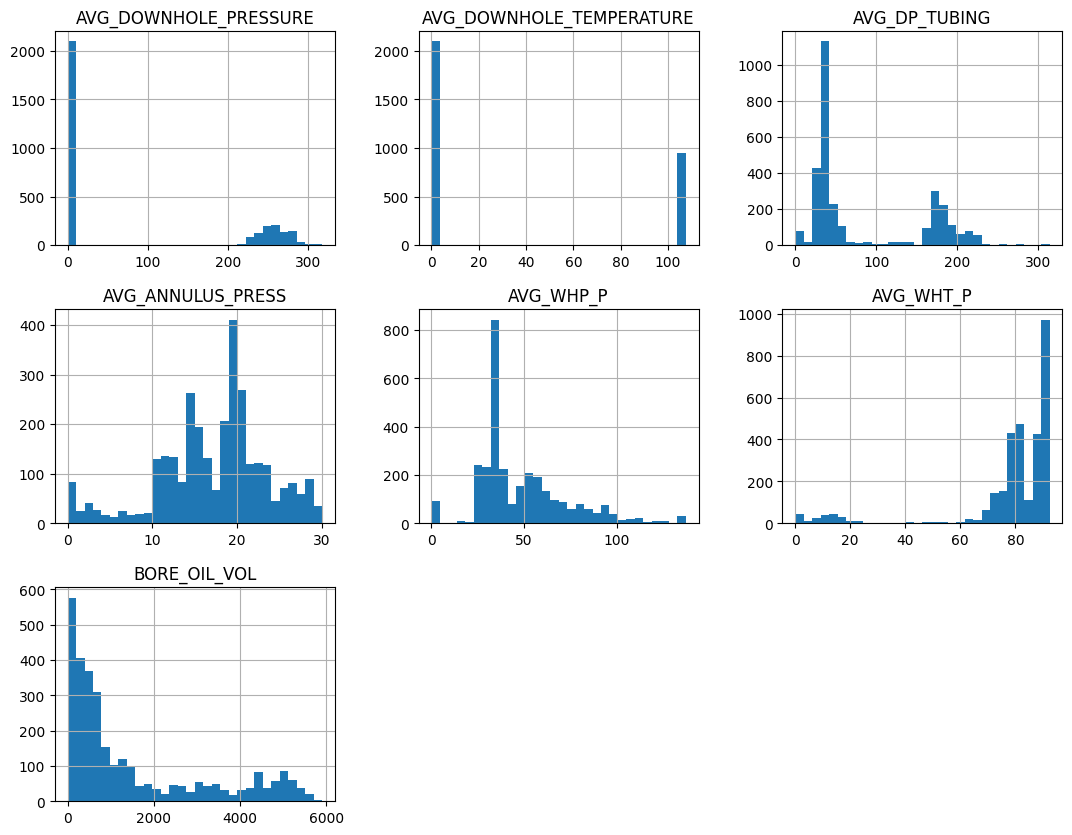

In [ ]:
df.hist(bins=30, figsize=(13,10))
plt.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/SMARTWELL_HISTPLOT.png', dpi = 600)

In [ ]:
df.columns


Index(['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
       'AVG_ANNULUS_PRESS', 'AVG_WHP_P', 'AVG_WHT_P', 'BORE_OIL_VOL'],
      dtype='object')

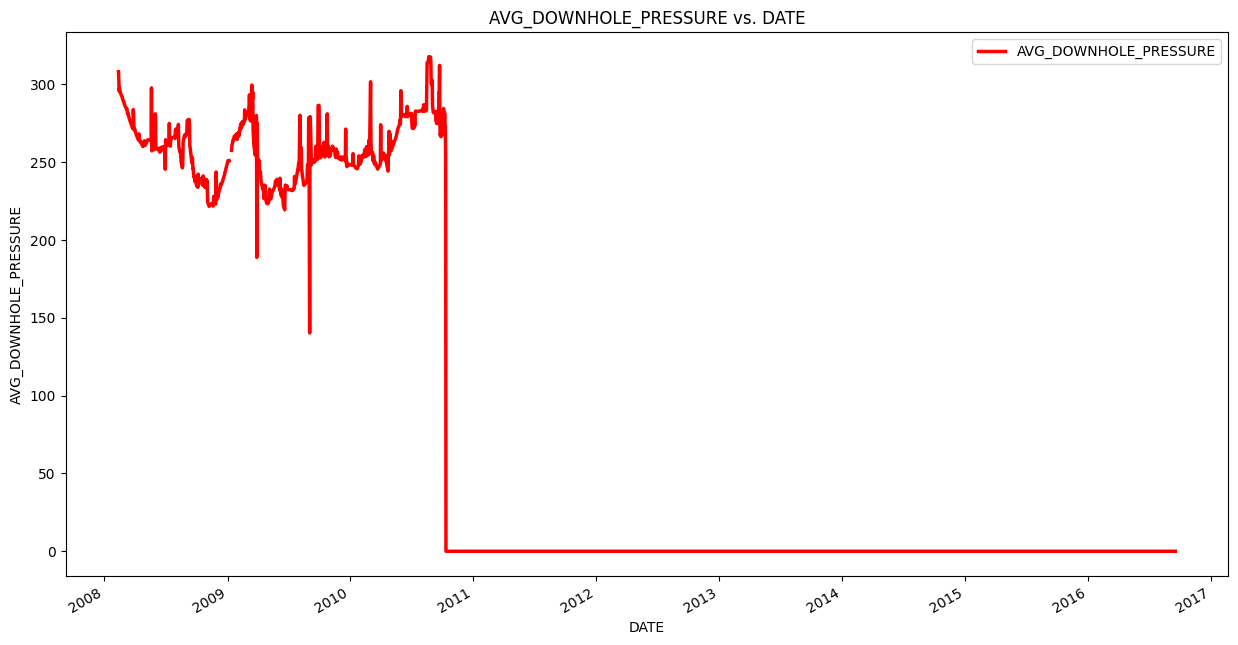

In [ ]:
import matplotlib.pyplot as plt
df.plot(y='AVG_DOWNHOLE_PRESSURE', figsize=(15, 8), linewidth=2.5, color='red')
plt.xlabel('DATE')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.title('AVG_DOWNHOLE_PRESSURE vs. DATE')
plt.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/SMARTWELL_AVG_DOWNHOLE_PRESSURE.png', dpi = 600)
plt.show()

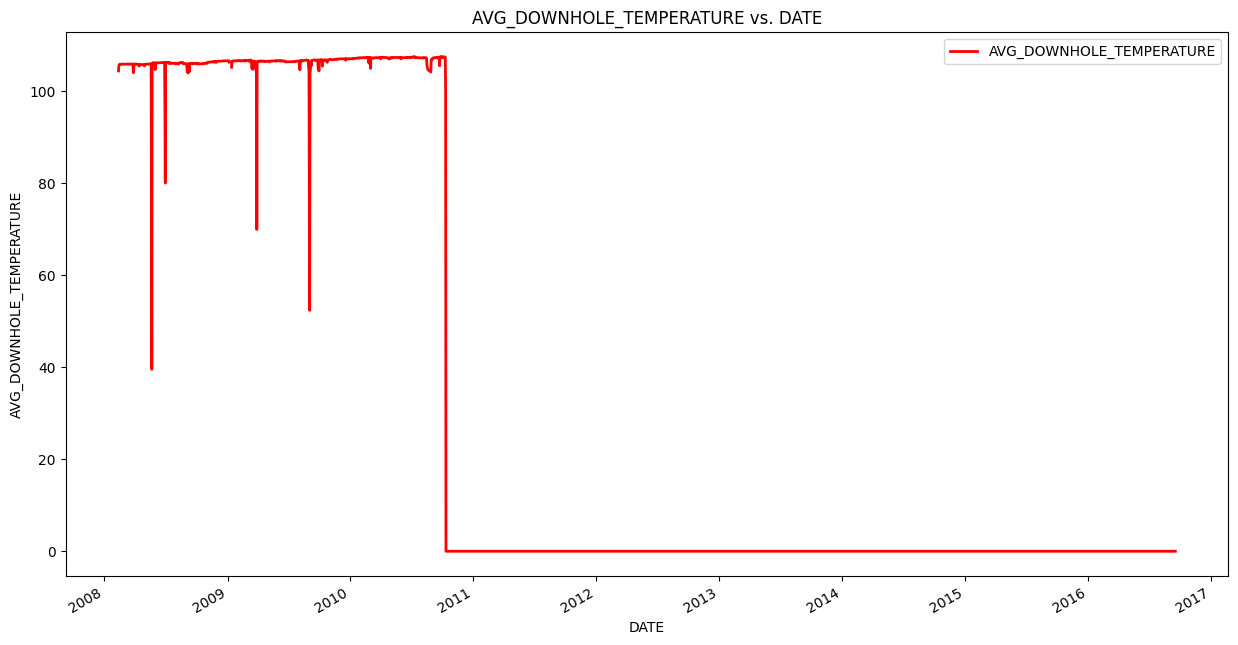

In [ ]:
import matplotlib.pyplot as plt
df.plot(y='AVG_DOWNHOLE_TEMPERATURE', figsize=(15, 8), linewidth=2, color='red')
plt.xlabel('DATE')
plt.ylabel('AVG_DOWNHOLE_TEMPERATURE')
plt.title('AVG_DOWNHOLE_TEMPERATURE vs. DATE')
plt.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/SMARTWELL_AVG_DOWNHOLE_TEMPERATURE.png', dpi = 600)
plt.show()

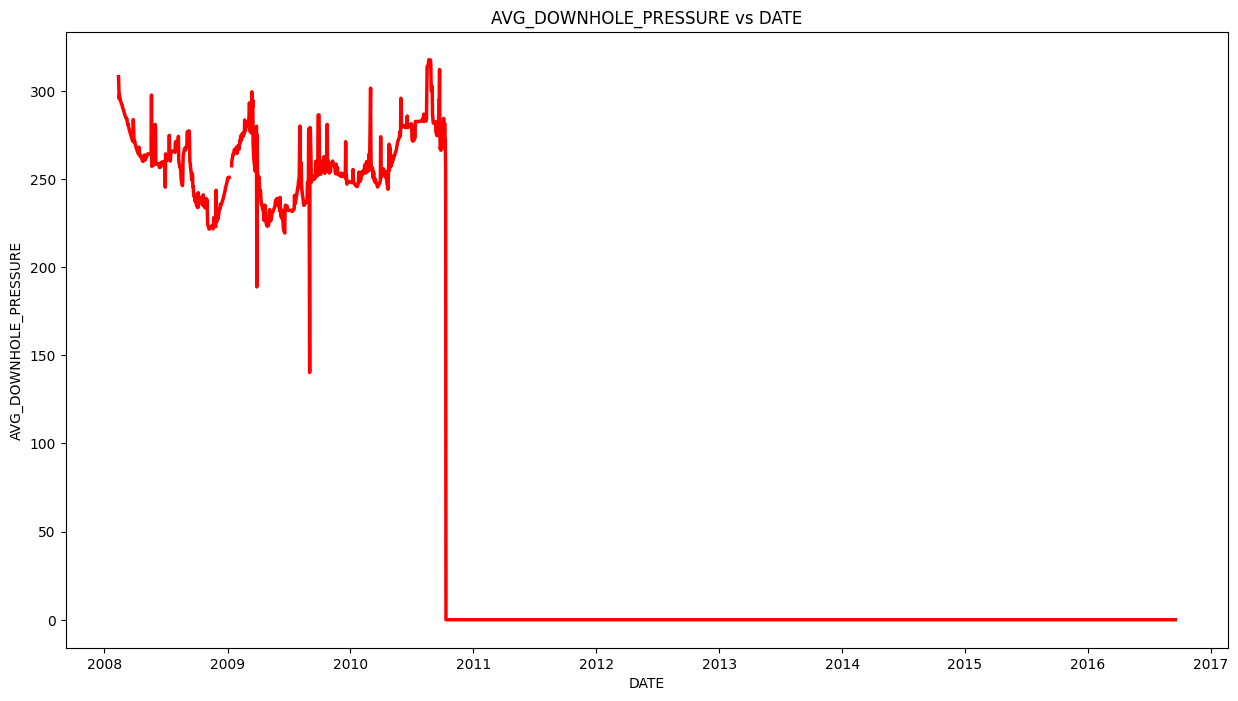

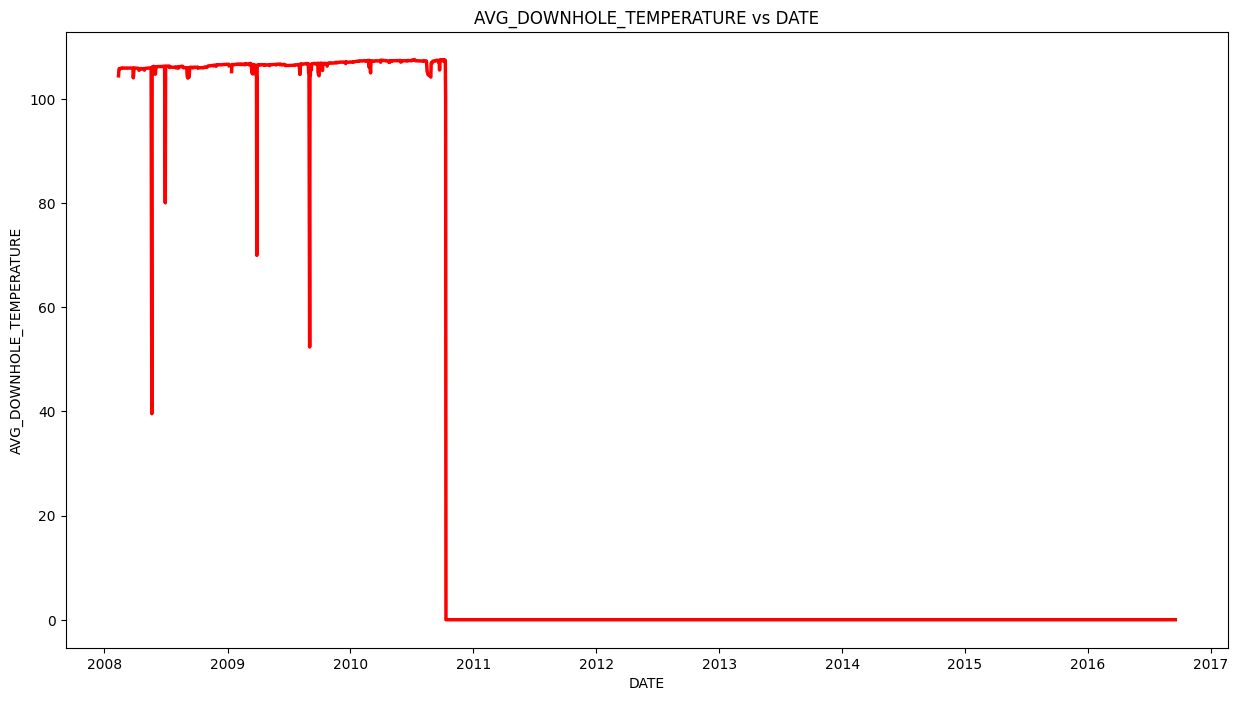

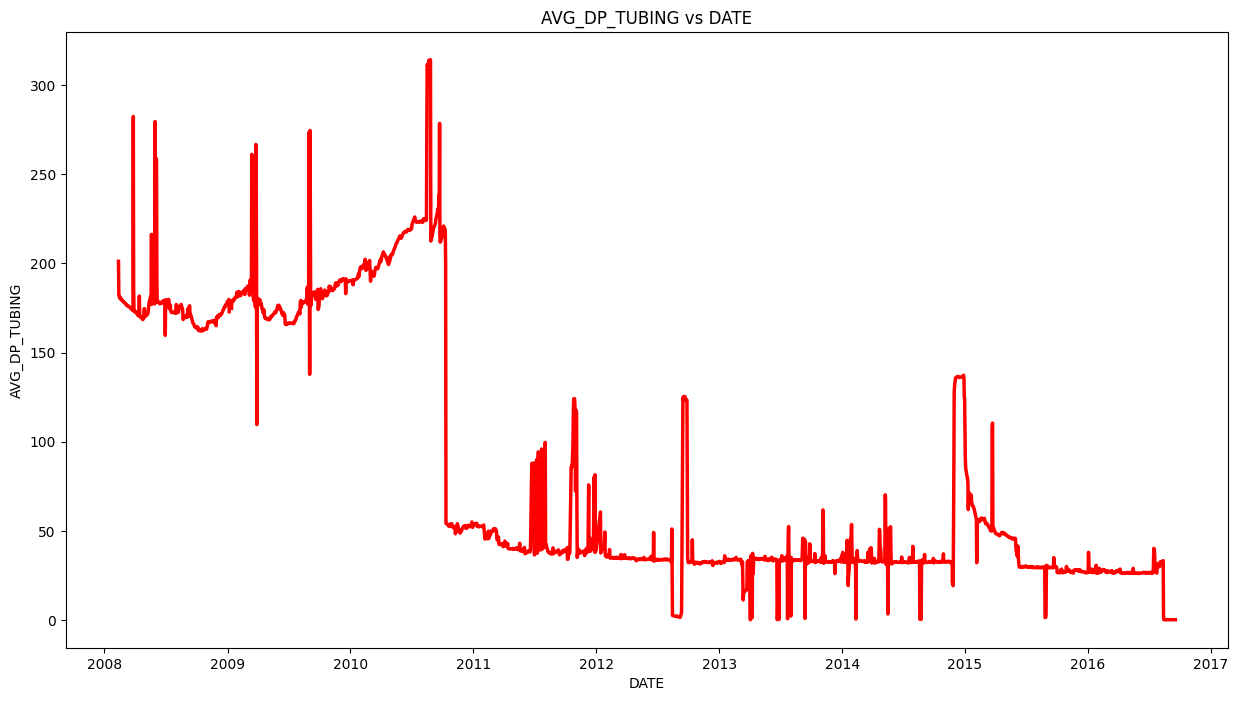

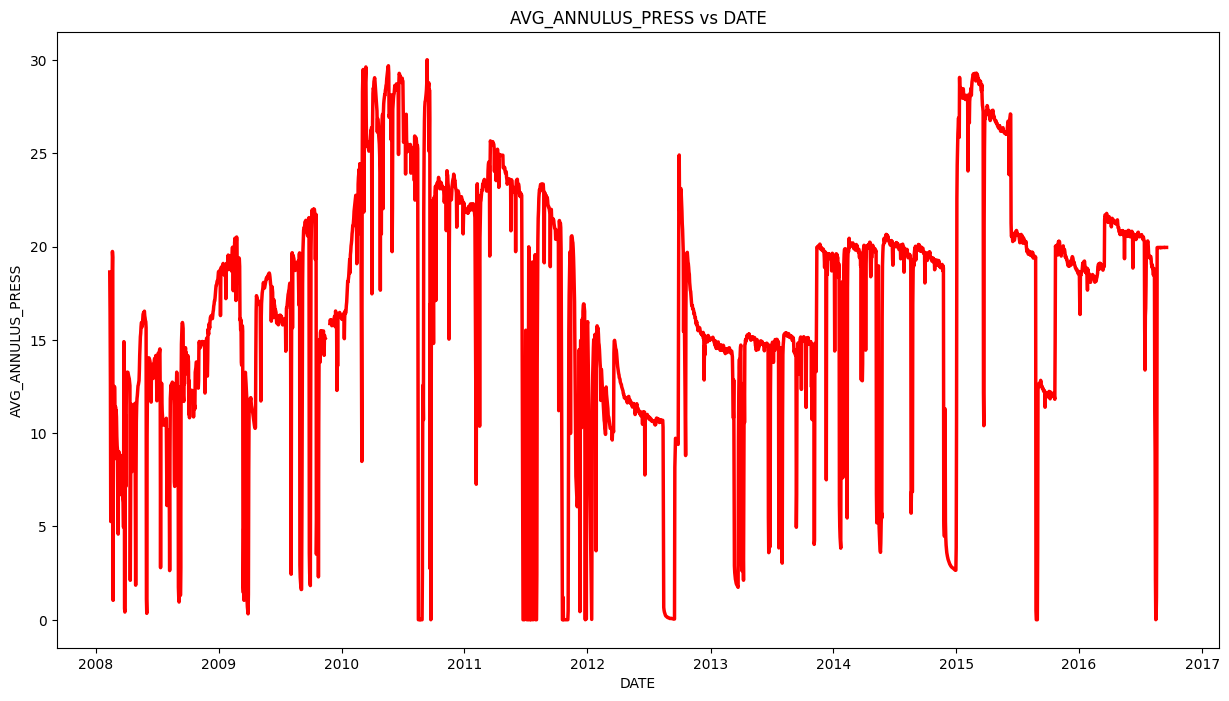

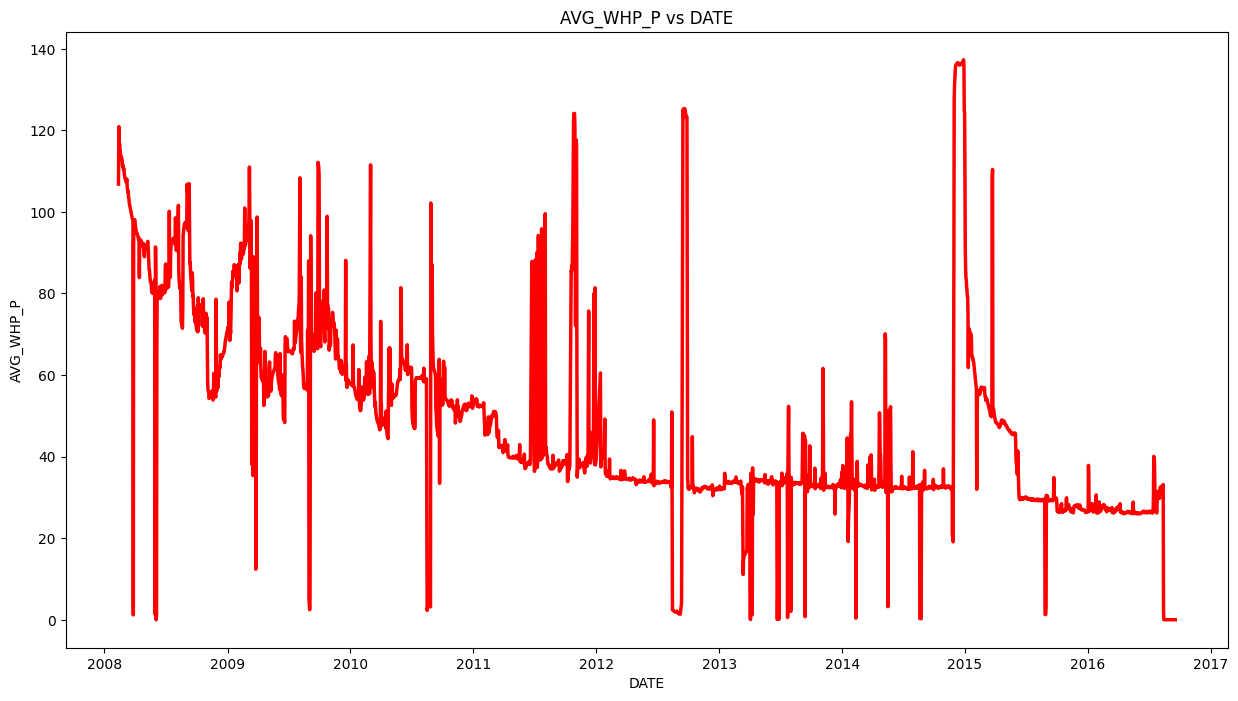

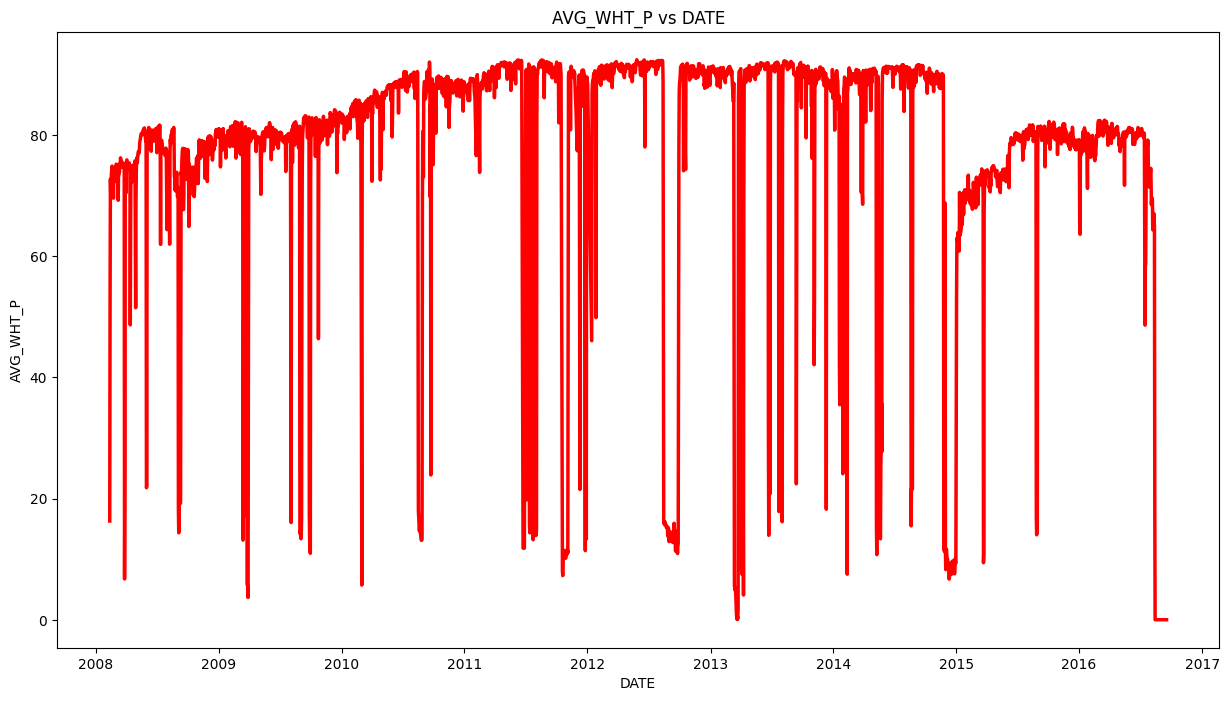

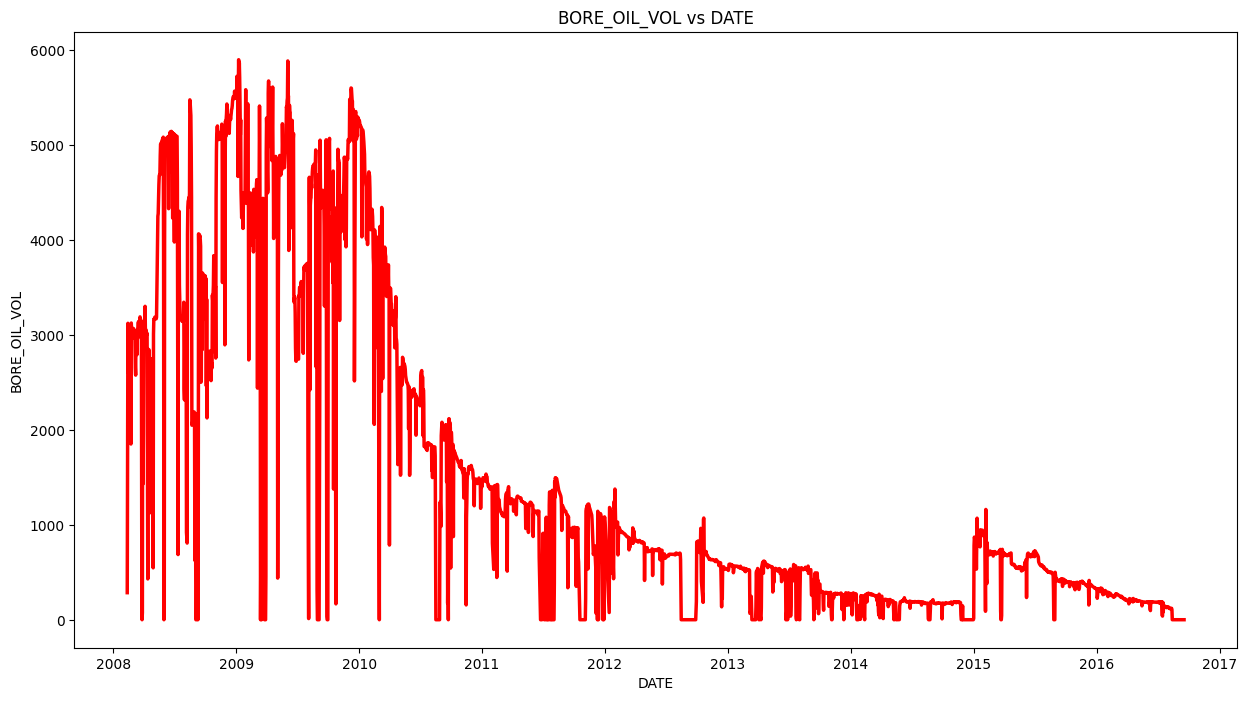

In [ ]:
for column in df.columns:
    plt.figure(figsize=(15, 8))
    plt.plot(df.index, df[column], linewidth=2.5, color='red')
    plt.xlabel('DATE')
    plt.ylabel(column)
    plt.title(column + ' vs DATE')
    plt.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/' + column + '.png', dpi=300, bbox_inches='tight')
    plt.show()

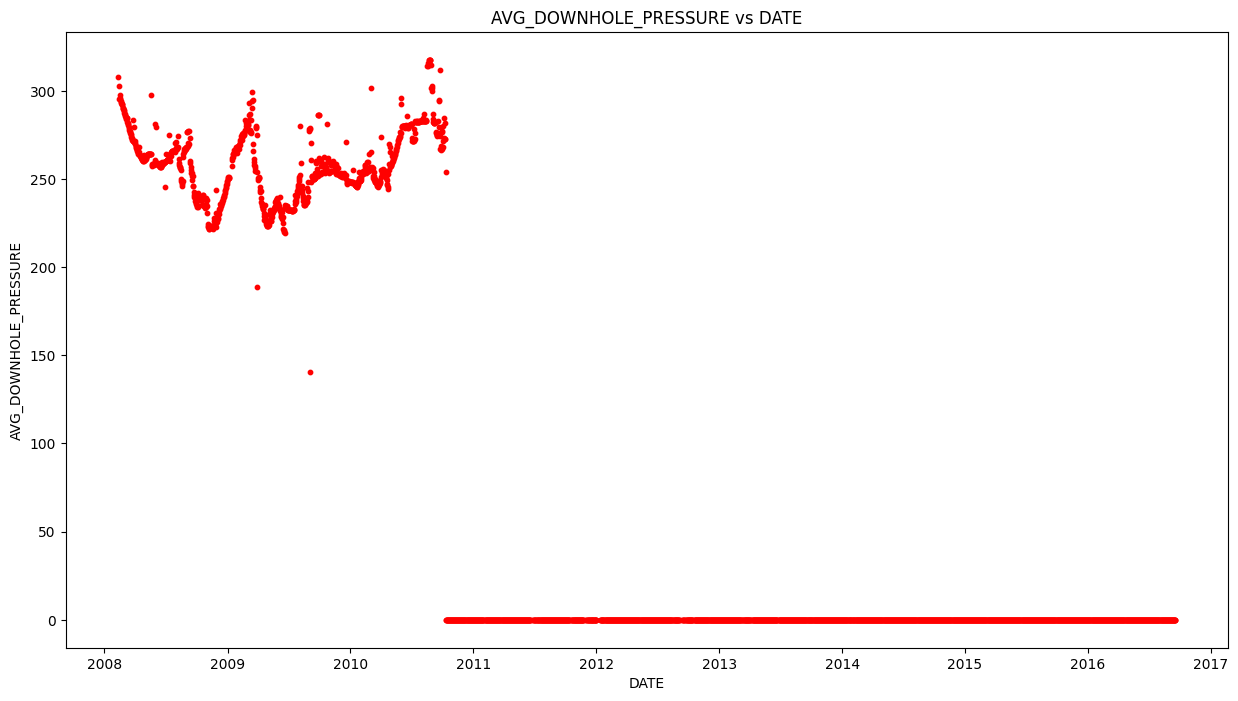

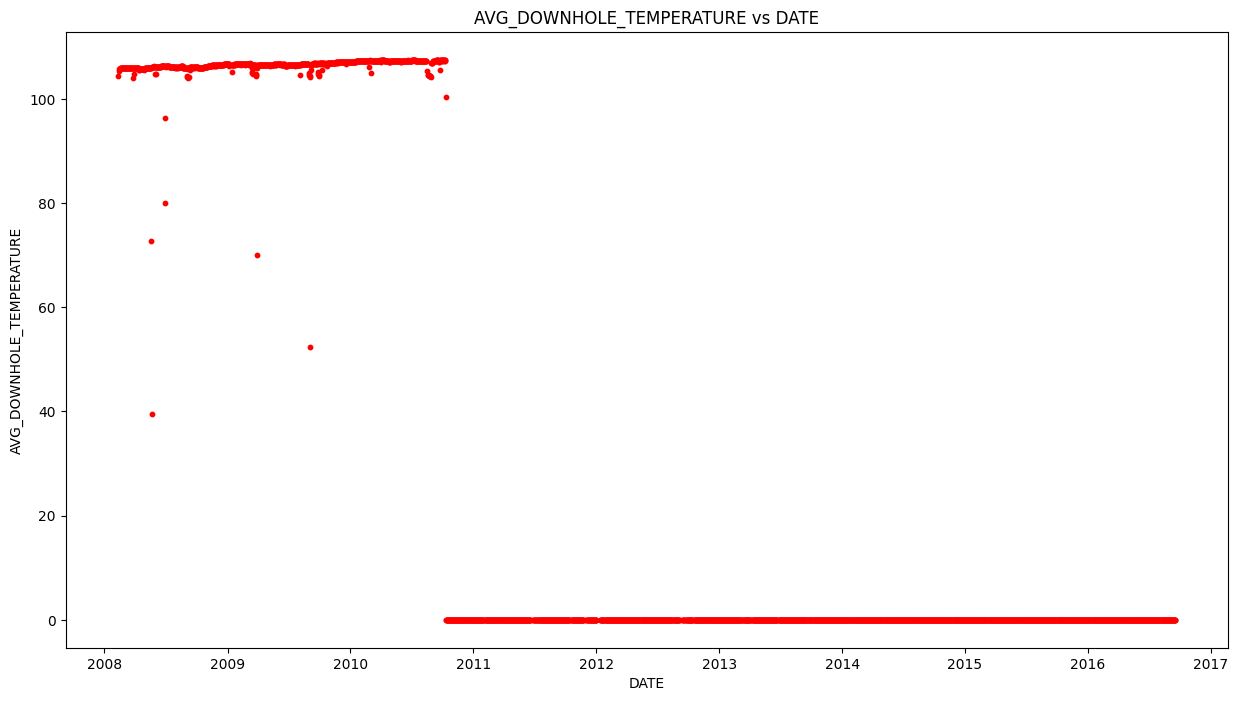

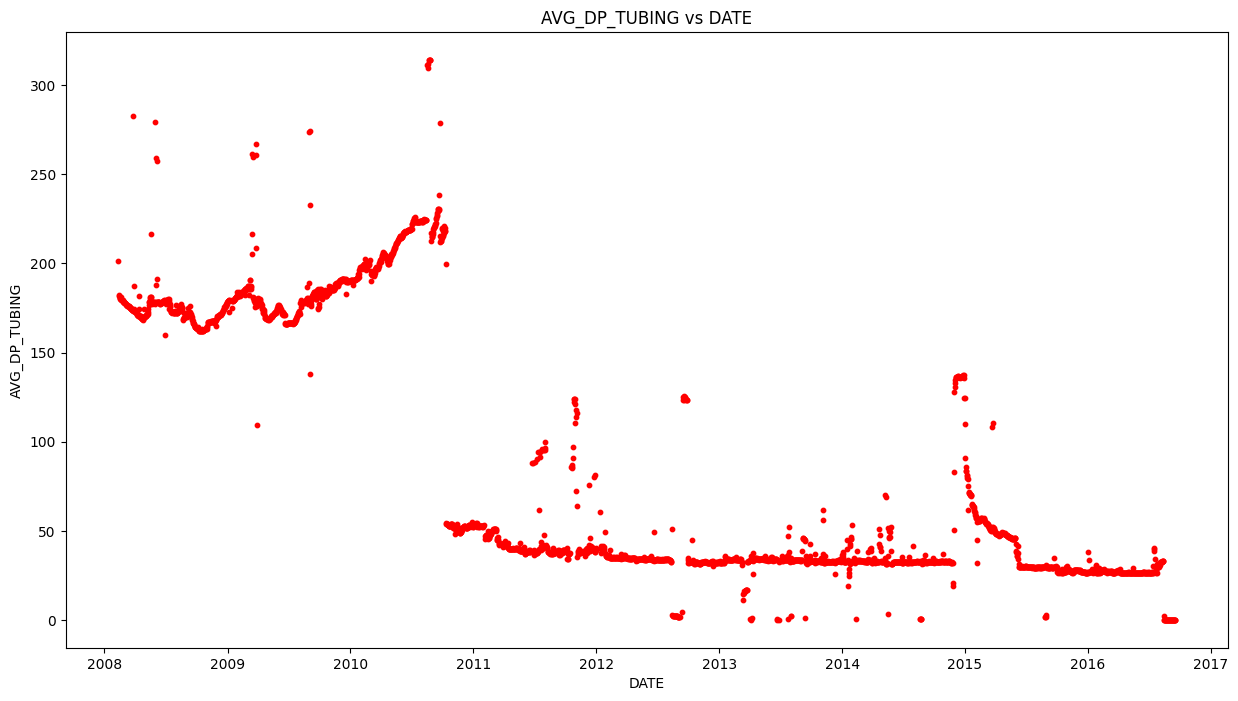

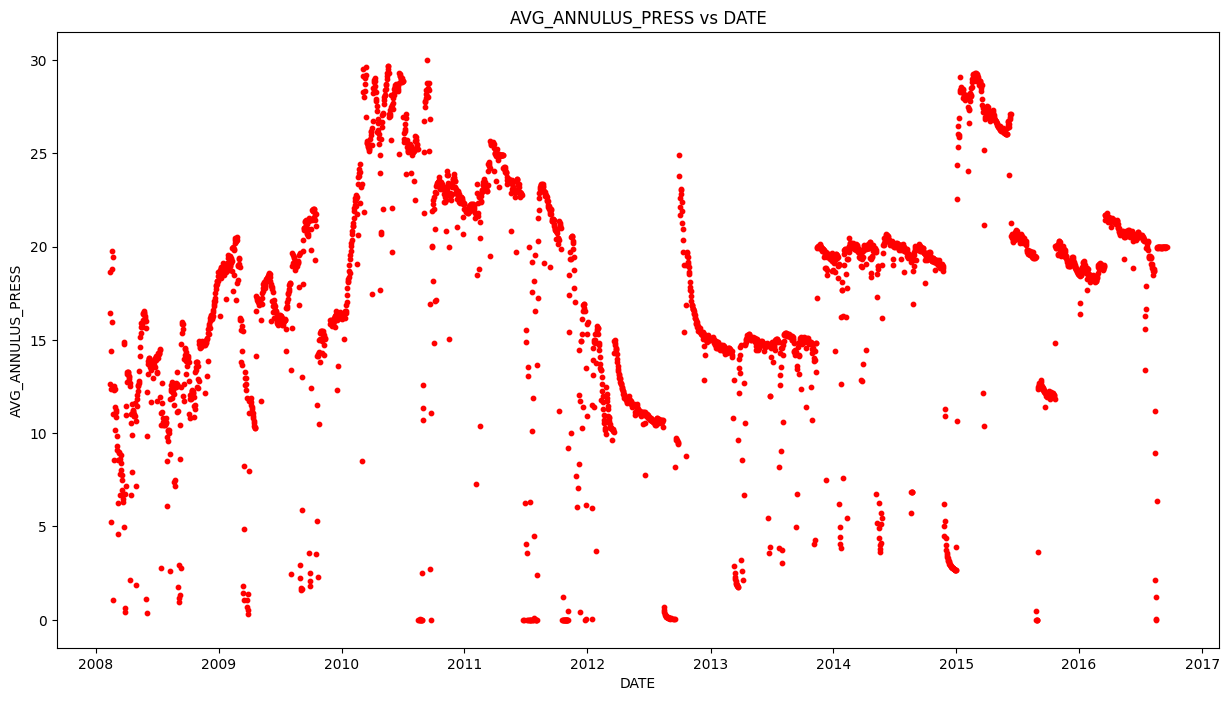

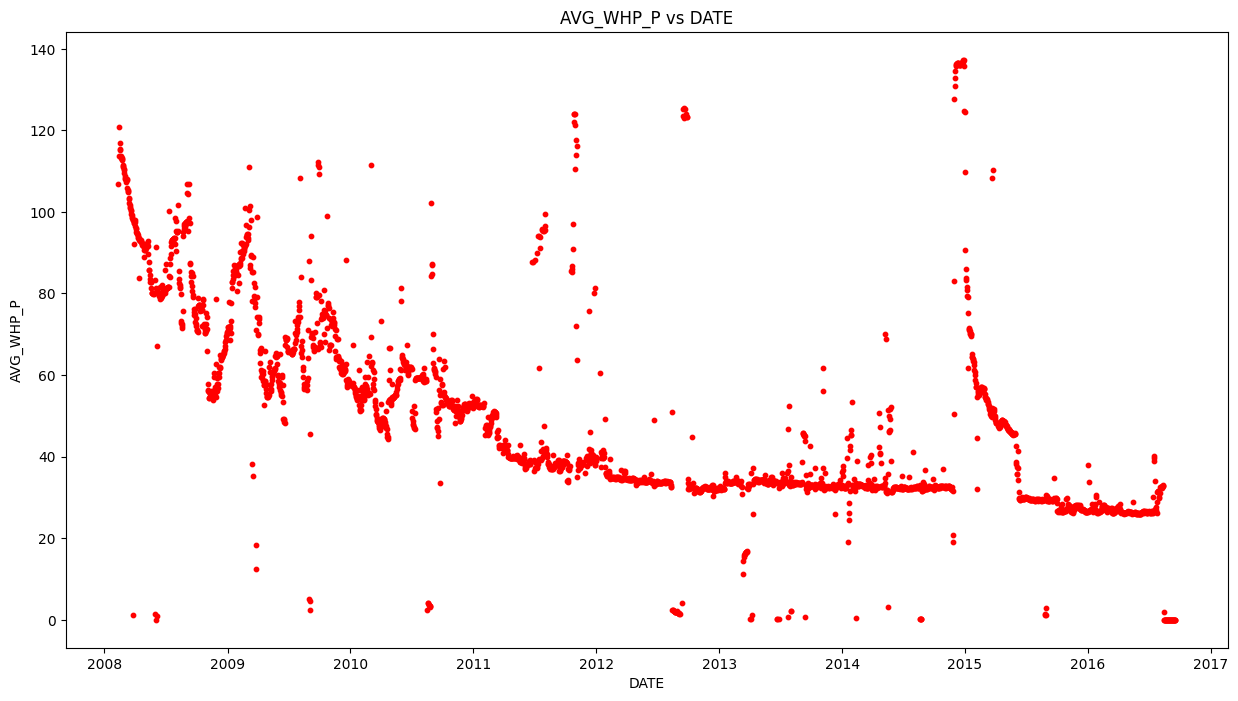

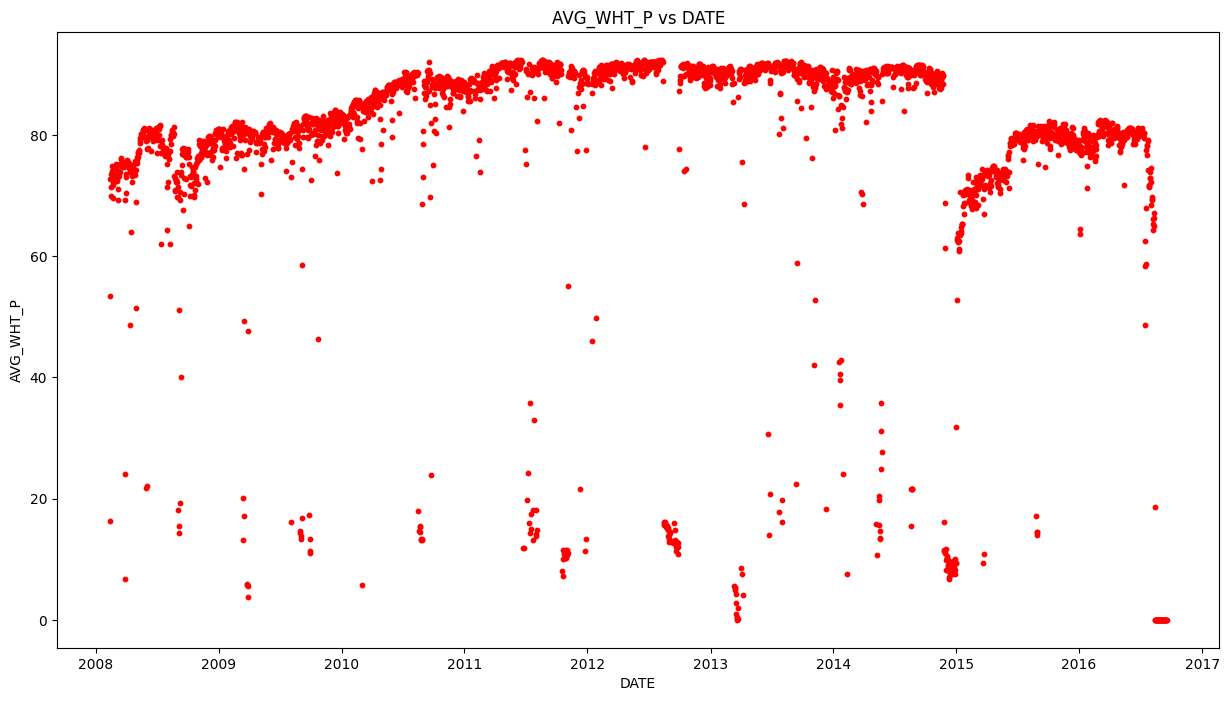

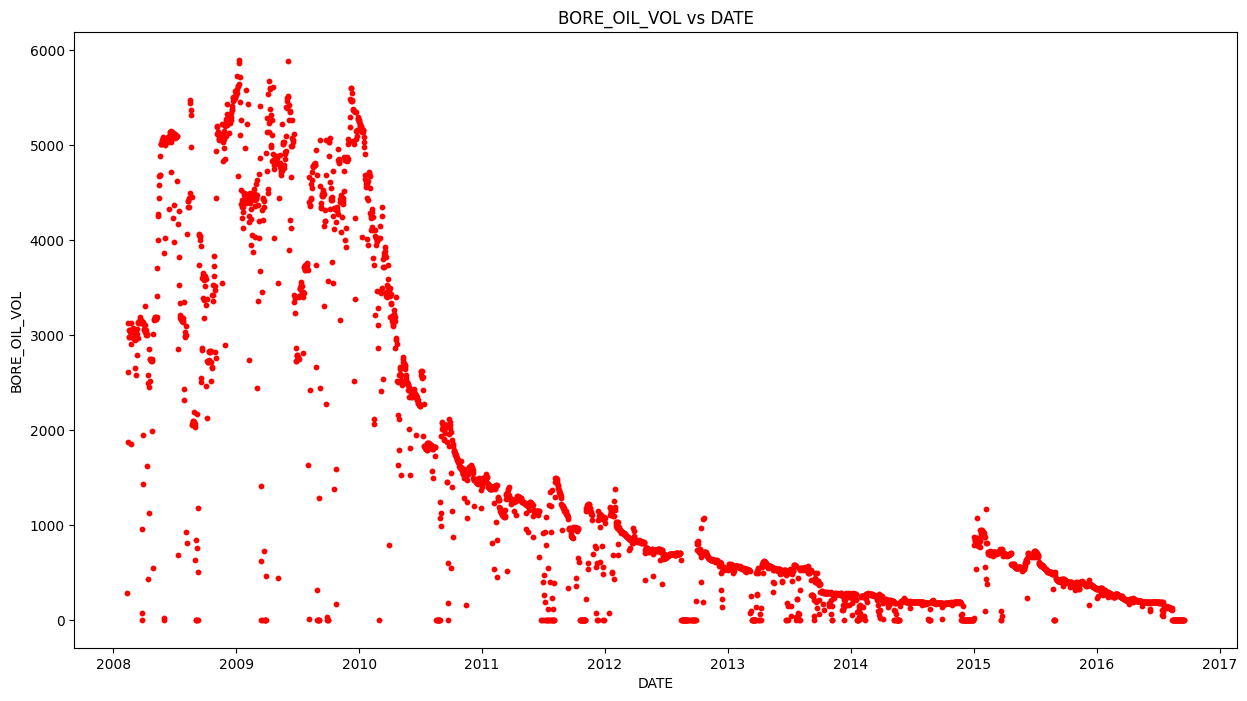

In [ ]:
for column in df.columns:
    plt.figure(figsize=(15, 8))
    plt.scatter(df.index, df[column], s=10, color='red')
    plt.xlabel('DATE')
    plt.ylabel(column)
    plt.title(column + ' vs DATE')
    plt.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/' + column + '.png', dpi=300, bbox_inches='tight')
    plt.show()

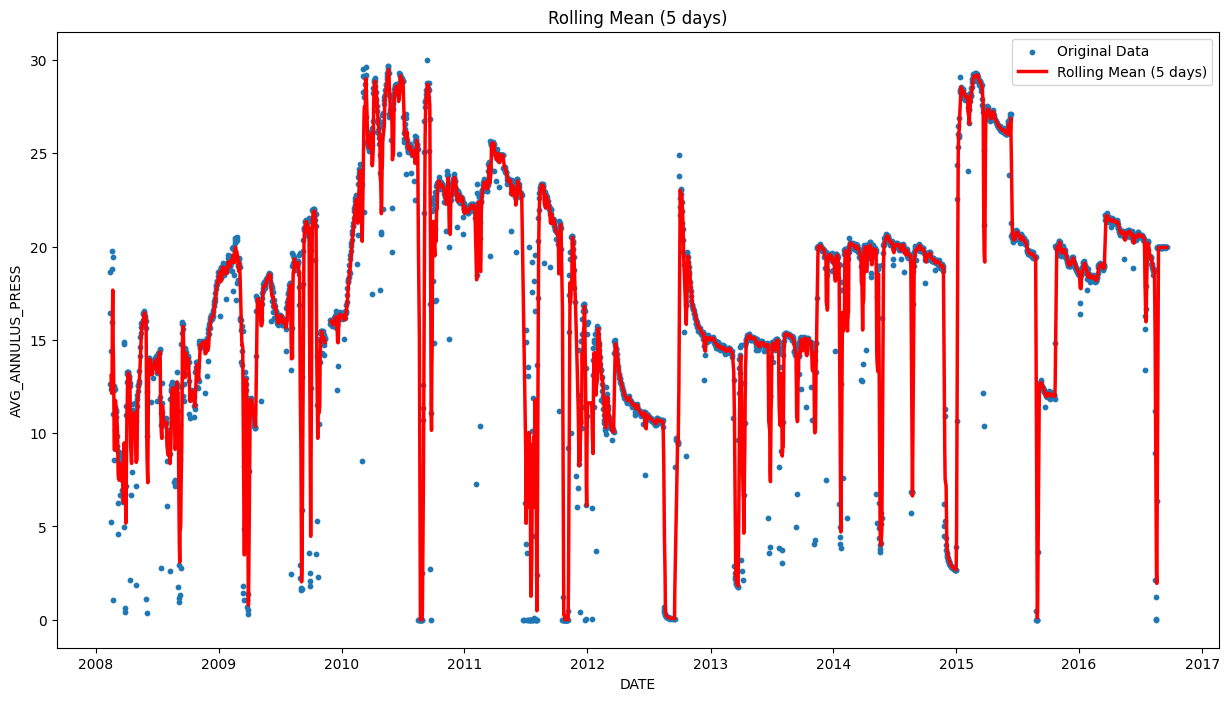

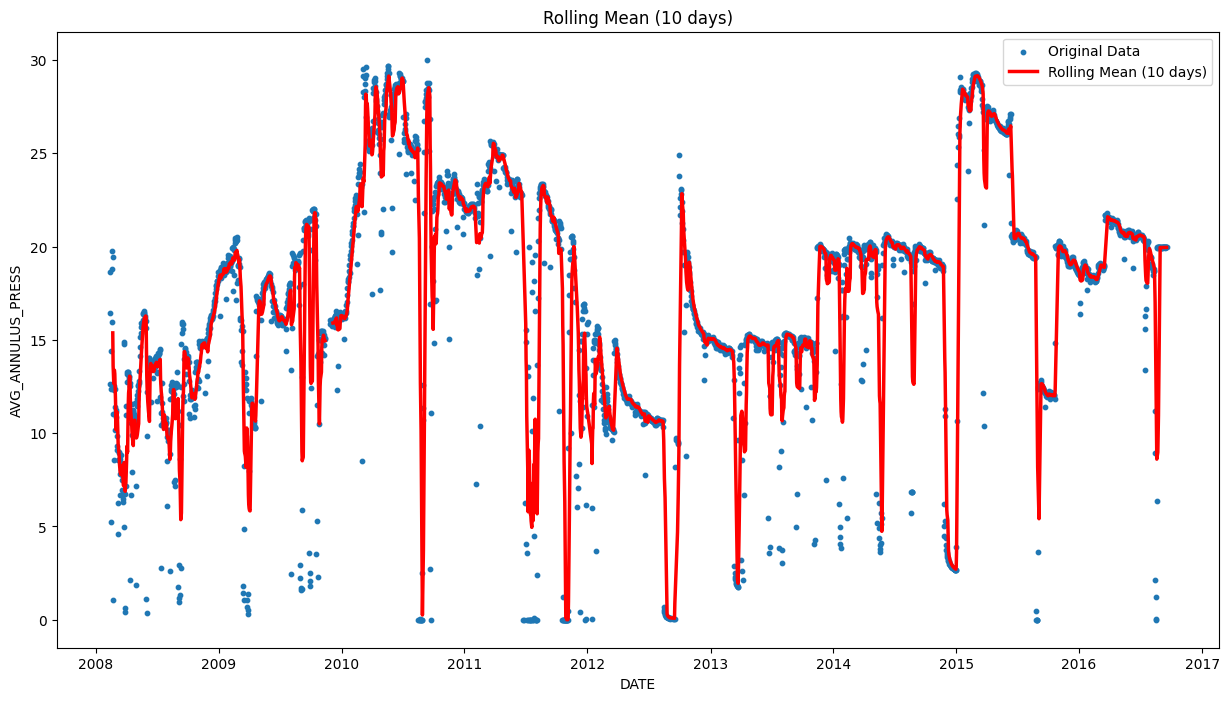

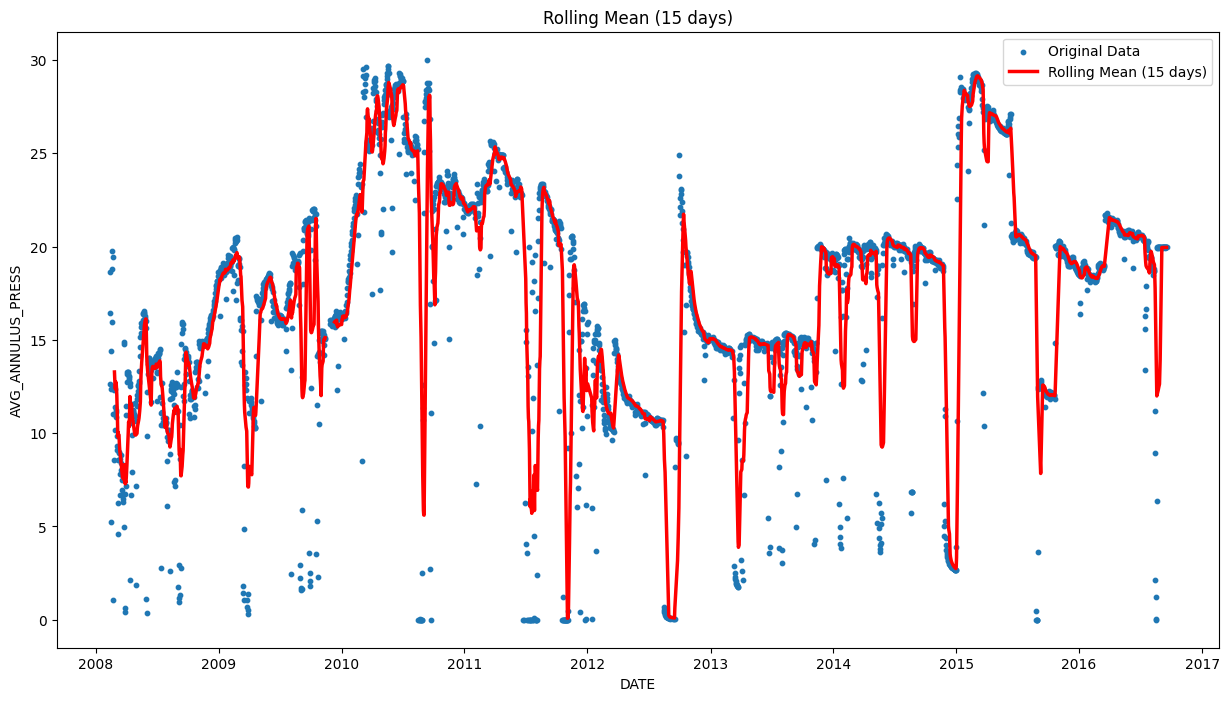

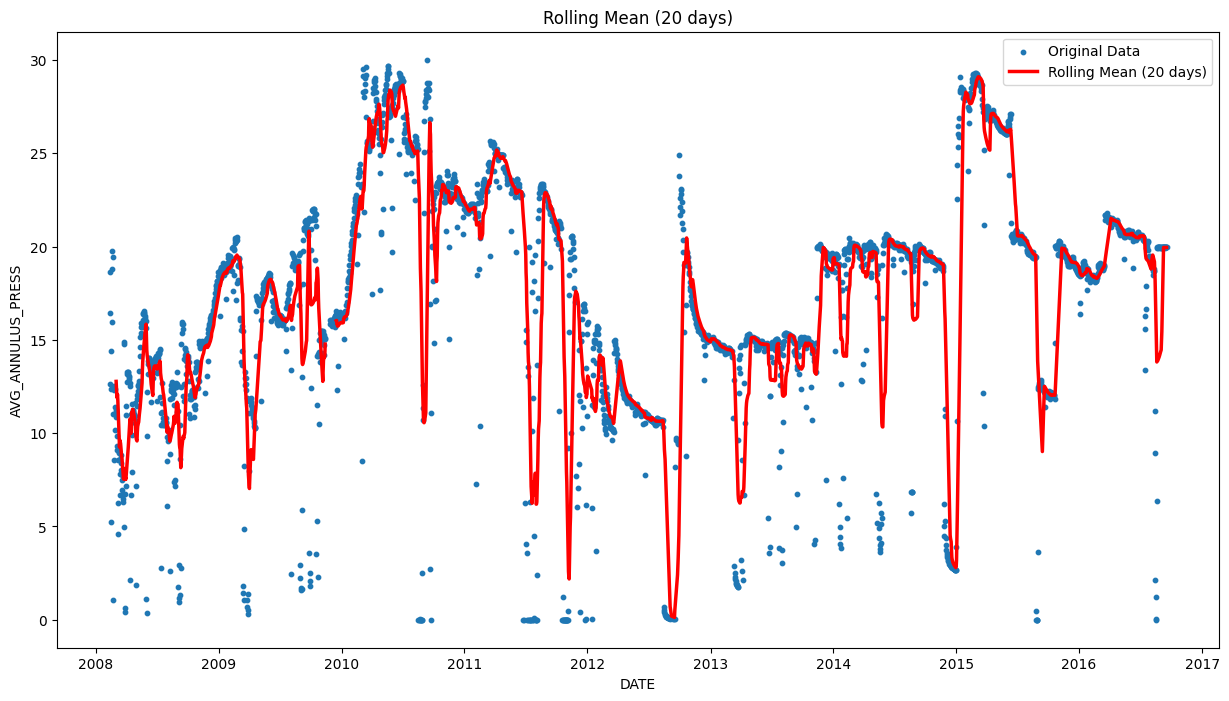

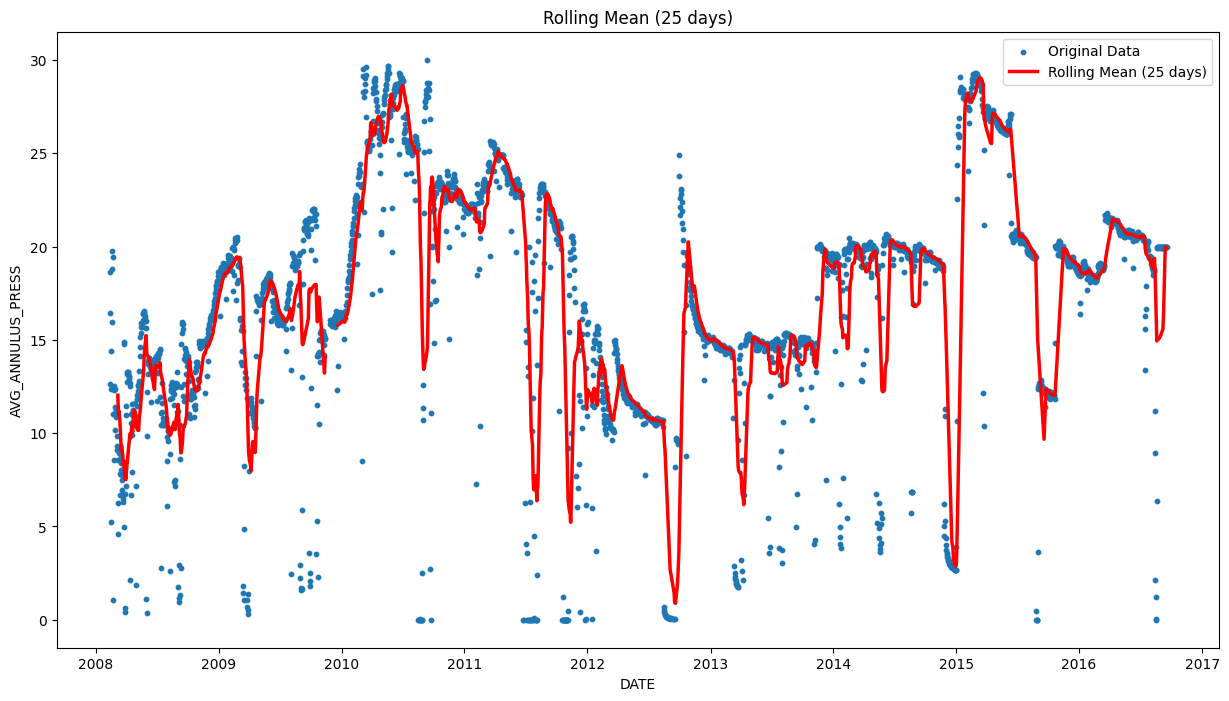

In [ ]:
windows = [5, 10, 15, 20, 25]
for w in windows:
    # create a new figure for each window size
    plt.figure(figsize=(15, 8))
    
    # calculate rolling mean
    rolling_mean = df.rolling(window=w).mean()
    
    # plot scatter of original data
    plt.scatter(df.index, df['AVG_ANNULUS_PRESS'], label='Original Data', s=10)
    
    # plot line of rolling mean
    plt.plot(rolling_mean.index, rolling_mean['AVG_ANNULUS_PRESS'], label=f'Rolling Mean ({w} days)', linewidth=2.5, color='red')
    
    # set plot title and labels
    plt.xlabel('DATE')
    plt.ylabel('AVG_ANNULUS_PRESS')
    plt.title(f'Rolling Mean ({w} days)')
    plt.legend()
    
    # save plot to file
    plt.savefig(f'/content/drive/MyDrive/01_Project_Reservoir_Description/Data/Rolling Mean ({w} days).png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()


In [ ]:
df.columns


Index(['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
       'AVG_ANNULUS_PRESS', 'AVG_WHP_P', 'AVG_WHT_P', 'BORE_OIL_VOL'],
      dtype='object')

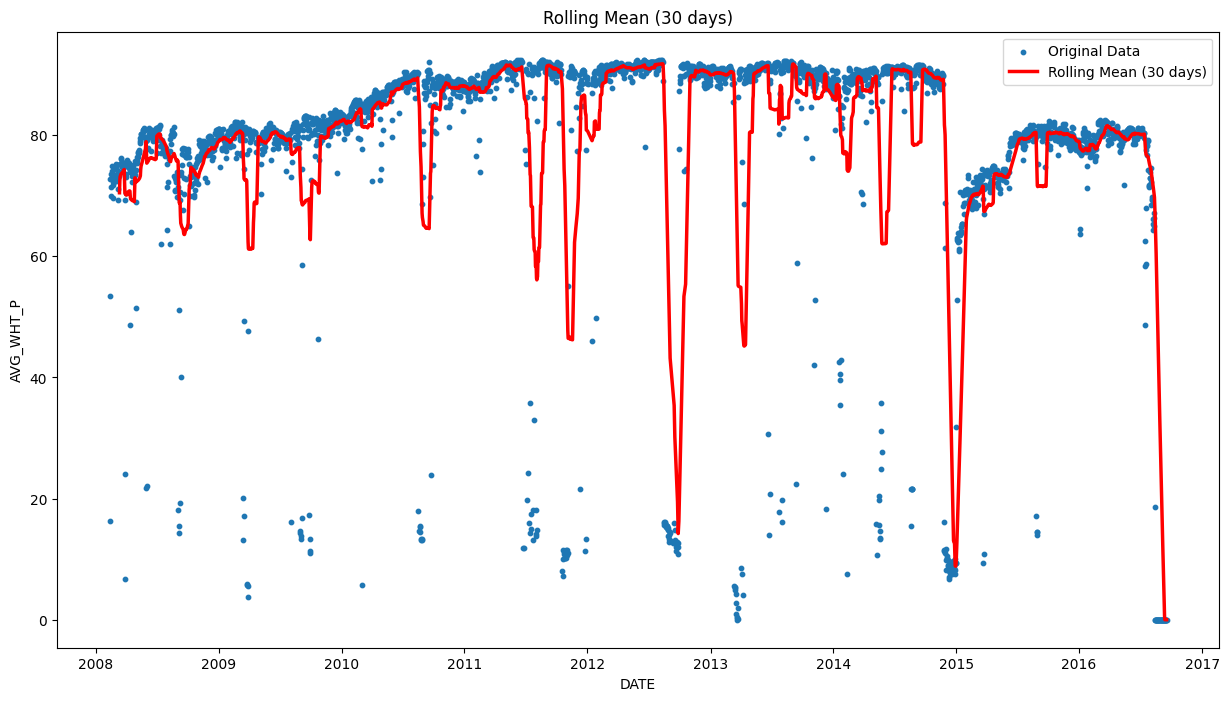

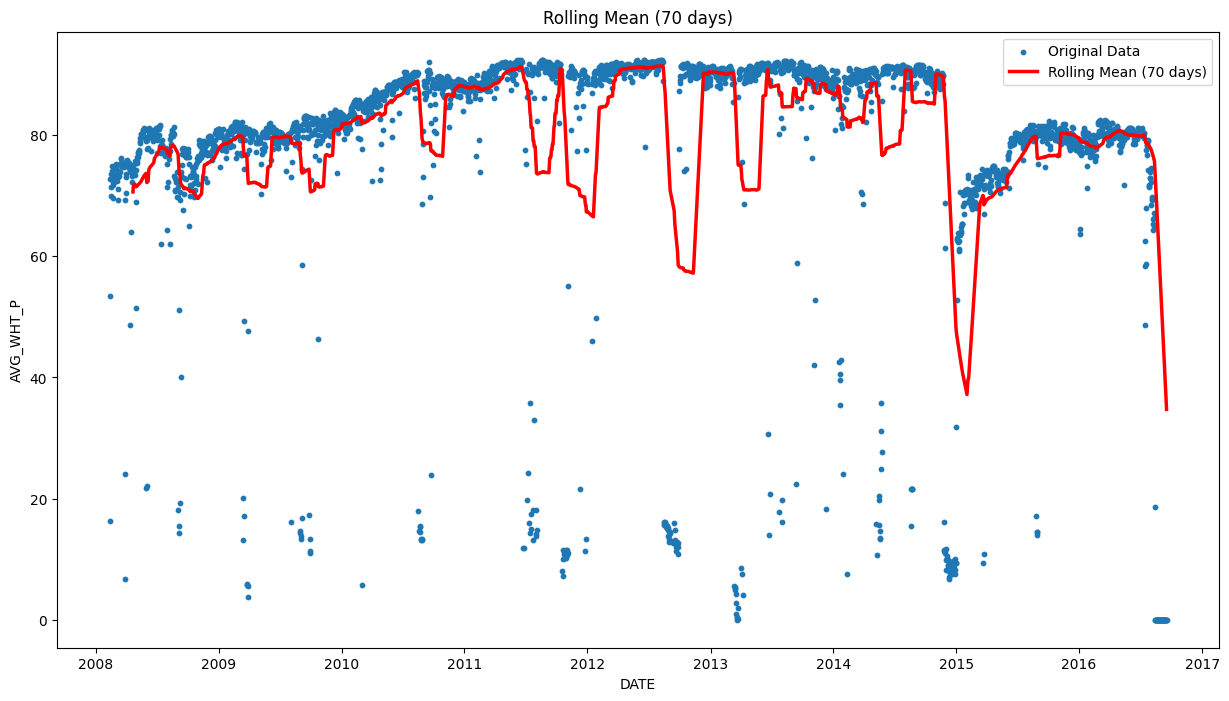

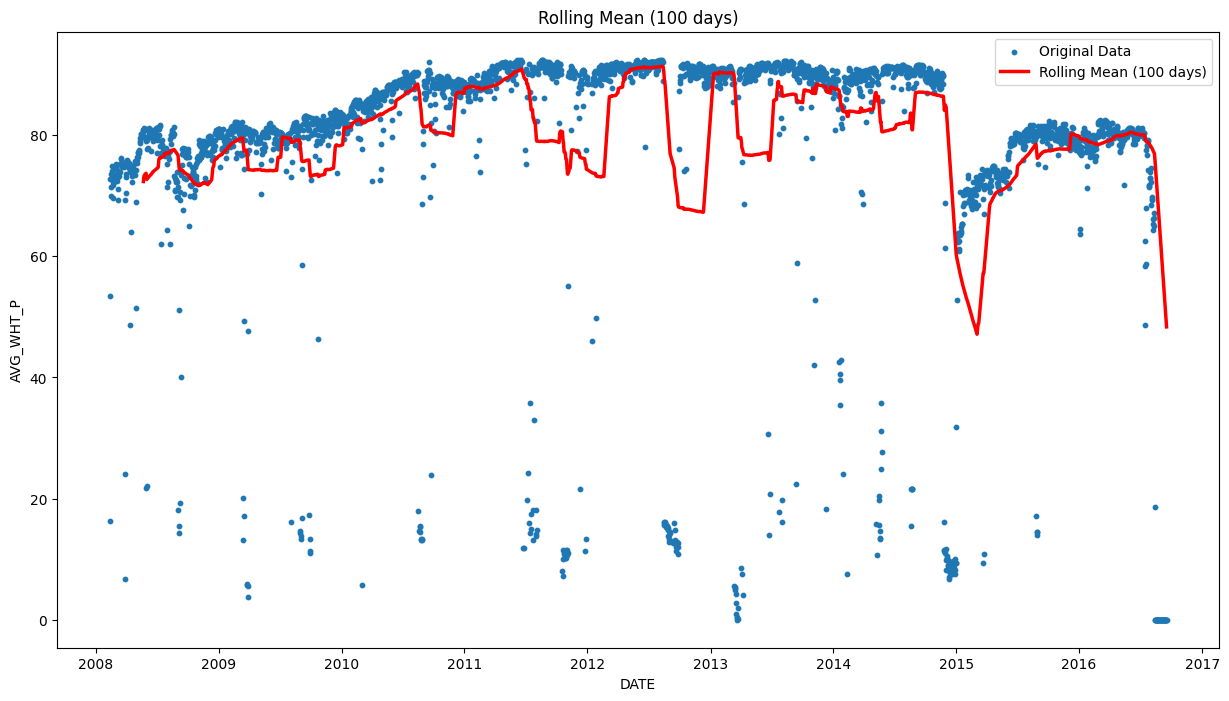

In [ ]:
windows = [30, 70, 100]
for w in windows:
    # create a new figure for each window size
    plt.figure(figsize=(15, 8))
    
    # calculate rolling mean
    rolling_mean = df.rolling(window=w).mean()
    
    # plot scatter of original data
    plt.scatter(df.index, df['AVG_WHT_P'], label='Original Data', s=10)
    
    # plot line of rolling mean
    plt.plot(rolling_mean.index, rolling_mean['AVG_WHT_P'], label=f'Rolling Mean ({w} days)', linewidth=2.5, color='red')
    
    # set plot title and labels
    plt.xlabel('DATE')
    plt.ylabel('AVG_WHT_P')
    plt.title(f'Rolling Mean ({w} days)')
    plt.legend()
    
    # save plot to file
    plt.savefig(f'/content/drive/MyDrive/01_Project_Reservoir_Description/Data/Rolling Mean ({w} days).png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()


In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax', transform= 'yeo-johnson' , poly = 3), X.columns )])


from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3, n_iter=50,  n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 79, 'algo__max_features': 0.3347462573473682, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 147, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.9962643730493114 0.9708219201338145 0.9547206956691668


In [ ]:
X = df.drop(columns="BORE_OIL_VOL")
y = df.BORE_OIL_VOL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2139, 11), (917, 11), (2139,), (917,))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

X = df.drop(columns="BORE_OIL_VOL")
y = df.BORE_OIL_VOL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(impute = 'median'), X.columns )])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model_LR = RandomizedSearchCV(pipeline, rsp.linreg_params, cv=3, n_iter=50,  n_jobs=-1, verbose=1, random_state=42)
model_LR.fit(X_train, y_train)

print(model_LR.best_params_)
print(model_LR.score(X_train, y_train), model_LR.best_score_, model_LR.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'algo__fit_intercept': True}
0.8152183307669595 0.8091710538388585 0.8262097604769435
